In [15]:
import os
import numpy as np
import pylab as plt
import sys
import lsst.daf.persistence as dafPersist
from scipy.stats import iqr
import lsst.afw.detection as afwDetection
import lsst.afw.math as afwMath

%matplotlib inline
plt.style.use('seaborn-poster') 


In [16]:
plt.style.use('seaborn-poster')  #Need to run in twice

In [17]:
butler = dafPersist.Butler(inputs=['/project/plazas/calibrations_feb11'])

In [18]:
r_band_flats = butler.queryMetadata('raw', ('visit'), dataId = {'imageType': 'FLAT', 'run': 9120, 'filter': 'r'})

In [29]:
class hot_and_cold_pixels():
    """
    Jira ticket: DM-17490
    Find the cold pixels in a master flat (value < threshold)
    and the hot pixels in a master dark (value > threshold). 
    'Threshold' is given by a factor times the standard deviation (sigma)
    of the distribution of pixels in a given detector. 
    Sigma is calculated as 'sigma=iqr(pixel_array)*1./1.34896' (robust determination of sigma
    in a Gausian distribution; iqr=inter-quartile range=Q3-Q1).
    """
    def __init__(self, master, detector, type='dark', number_of_sigma_threshold=5.5, pdf=False, polarity=True):
        self.type=type
        if not self.type in ['flat','dark']:
            print ("Enter a valid master image type: 'flat' or 'dark'")
            sys.exit[1]
        self.master = master #e.g., master=butler.get('dark', dataId = { 'run': 9120, 'visit': flats_visits[0], 'detector':18, 'dayObs': '2018-09-11'})
        self.masked_image = self.master.getMaskedImage()
        #self.colthreshold = 20
        self.sigma_threshold=number_of_sigma_threshold
        self.pdf=pdf
        self.detector=detector
        self.polarity=polarity #if master_dark, set to 'True'; if master_flat, set to 'False'
        
    def run(self,):
        # determine threshold values per amp
        #self.thresholds = self.dark_thresh(self.dark, self.percentile)
        # plot out the pixel distributions of the amps. Also retursn thresholds, as sigma values. 
        self.thresholds= self.plot_amp_hist(self.master, self.pdf, self.detector) #, self.thresholds)
        # mask hot pixels in place
        footprints = self.mask_hot_and_cold_pixels(self.master, self.thresholds)
        #self.mask_bright_columns(self.dark, self.colthreshold)
        self.print_footprints_ascii (footprints)
        return 
                
    
    def plot_amp_hist(self, master, pdf, detector):
        '''
        make a histogram of the distribution of pixel values for each amp. 
        '''
        f, ax = plt.subplots(nrows=4, ncols=4, sharex='col', sharey='row', figsize=(20, 10))
        amps = master.getDetector()
        thresh={}
        for amp, a in zip(amps, ax.flatten()):
            #Calculate mean and std of amplifier
            mi = self.masked_image[amp.getBBox()].clone()
            stats = afwMath.makeStatistics(mi, afwMath.MEAN | afwMath.STDEV)
            mean = stats.getValue(afwMath.MEAN)
            sigma = stats.getValue(afwMath.STDEV)
            
            #Get array of pixels
            work_img_data = self.masked_image[amp.getBBox()].getImage().array.flatten()
            #mean = np.mean(work_img_data)
            if mean > 0:  #shift the mean of the distribution to zero
                work_img_data-=mean
            else: 
                work_img_data+=mean
            mean = np.mean(work_img_data)  # Should be close to zero

            #Robust estimation of sigma: UPDATE: replaced by afw calculation above. 
            #sigma = iqr (work_img_data) * 1./1.34896 #iqr from scipy
                     
                
            threshold1 = mean + self.sigma_threshold*sigma
            threshold2 = mean - self.sigma_threshold*sigma
            nright=len(work_img_data[work_img_data > threshold1])
            nleft=len(work_img_data[work_img_data < threshold2])
            ntot=len(work_img_data)
                        
            print ("Name: ", amp.getName(),"Mean: ", mean,"Sigma: ", sigma,"Ntot: ", ntot,"Nleft: ", nleft,"Nright: ", nright)
            #print ("T1: ", threshold1, "T2: ", threshold2 )

            nbins=np.linspace(mean - 4*self.sigma_threshold*sigma , mean + 4*self.sigma_threshold*sigma,100) #darks
            y, bin_borders, patches = a.hist(work_img_data, histtype='step', bins=nbins, lw=3)
 
            
            thresh[amp.getName()] = threshold1  #construct dictionary of thresholds per amplifier
            a.axvline(threshold1, c='k')
            a.axvline(threshold2, c='k')

            a.text(0.6,0.6, f"{amp.getName()} \n mean:{mean:.2e} \n $\sigma$:{sigma:.2e}", \
                   transform=a.transAxes, fontsize=11)
            a.text(0.03,0.55, f"Nleft:{nleft} \n Nright:{nright}", \
                            transform=a.transAxes, fontsize=12)
            a.set_yscale('log')
            a.set_xlabel("ADU/s")

        if pdf:
            f.suptitle (f"Detector: {self.detector}, Type: {self.type} \n Threshold: {self.sigma_threshold}$\sigma$", fontsize=20 )
            pdf_out.savefig(f)
            
            
        return thresh
    
    def mask_hot_and_cold_pixels(self, master, thresh):
        '''
        using the thresholds for each amp, mask pixels that have been 
        tagged as being "> threshold" (hot in master dark) or "< -threshold" (cold in master flat). 
        This is done in place on the master input
        master: master dark or flat, afw exposure object
        output
        master: the same master dark or master flat, but now the mask plane has been updated inplace
        foorprint_vec: vector with footprints, to be printed in ASCII files (x y width height). 
        '''
        #loop over amps
        masked_img = master.getMaskedImage()
        footprint_vec=[]
        for amp in master.getDetector():
            name = amp.getName()
            detect_thresh = thresh[name]
            #print (f"threshold: {detect_thresh}")
            # create threshold object
            Threshold=afwDetection.createThreshold(detect_thresh, 'value', polarity=self.polarity) 
            #work_img = self.masked_image[amp.getBBox()]
            work_img = masked_img[amp.getBBox()]
            
            #Shift the mean of the image to zero. 
            mi = self.masked_image[amp.getBBox()].clone()
            stats = afwMath.makeStatistics(mi, afwMath.MEAN)
            mean = stats.getValue(afwMath.MEAN)
            #mean = np.mean(self.masked_image[amp.getBBox()].getImage().array)
            if mean > 0: 
                work_img-=mean
            else:
                work_img+=mean
            
            footprints = afwDetection.FootprintSet(work_img, Threshold).getFootprints()
            #print ("footprints:", len(footprints))
            defects = isrFunctions.defectListFromFootprintList(footprints)
            isrFunctions.maskPixelsFromDefectList(masked_img, defects)
            footprint_vec.append(footprints)
        return footprint_vec
    
    def mask_bright_columns(self, master, col_thresh):
        '''
        place holder function for now.
        find contiguous bright pixels in columns. If a column contains col_thresh
        contiguous hot pixels, then mask the entire column
        '''
        return
    
    def print_footprints_ascii (self, footprint_vec):
        '''
        Input
        --------
        footprint_vec: list of footprints
            footprint: 
                footprints = afwDetection.FootprintSet(work_img, Threshold).getFootprints()
        
        Output: 
        --------
        ASCII file of defects with the following columns: 
        x | y | width (bbox.getDimensions()[0]) | height (bbox.getDimensions()[1])
        
        '''
        file=open(f"defects_list_detector_{self.detector}_from_{self.type}.dat", 'w')
        file.write(f"# Defects File \n")
        file.write(f"# x | y | width | height \n")
        for footprints in footprint_vec:
            for f in footprints:
                for bbox in afwDetection.footprintToBBoxList(f):
                    #print (f"{bbox.getMinX()} {bbox.getMinY()} {bbox.getDimensions()[0]} {bbox.getDimensions()[1]}")
                    line=f"{bbox.getMinX()} {bbox.getMinY()} {bbox.getDimensions()[0]} {bbox.getDimensions()[1]} \n"
                    file.write(line)
        file.close()
        return 

Name:  C10 Mean:  -1.4204818e-08 Sigma:  0.016112846612254053 Ntot:  1018000 Nleft:  2340 Nright:  10
Name:  C11 Mean:  -1.9035312e-08 Sigma:  0.01575304223335581 Ntot:  1018000 Nleft:  2387 Nright:  13
Name:  C12 Mean:  1.4598571e-08 Sigma:  0.01653122128138021 Ntot:  1018000 Nleft:  2362 Nright:  93
Name:  C13 Mean:  2.8254241e-09 Sigma:  0.01588340481783399 Ntot:  1018000 Nleft:  2426 Nright:  22
Name:  C14 Mean:  -1.6693516e-08 Sigma:  0.01603431501216435 Ntot:  1018000 Nleft:  2422 Nright:  28
Name:  C15 Mean:  4.003699e-10 Sigma:  0.005998773573847181 Ntot:  1018000 Nleft:  2797 Nright:  26
Name:  C16 Mean:  -2.3489148e-08 Sigma:  0.015672348827872162 Ntot:  1018000 Nleft:  2470 Nright:  26
Name:  C17 Mean:  1.296038e-08 Sigma:  0.017533642357014205 Ntot:  1018000 Nleft:  2903 Nright:  12
Name:  C07 Mean:  1.9065991e-08 Sigma:  0.016643142144977283 Ntot:  1018000 Nleft:  2845 Nright:  8
Name:  C06 Mean:  2.3742556e-08 Sigma:  0.015207150910402482 Ntot:  1018000 Nleft:  2428 Nrigh

Name:  C13 Mean:  2.6649952e-08 Sigma:  0.016545595821695482 Ntot:  1018000 Nleft:  2404 Nright:  28
Name:  C14 Mean:  -2.9831362e-08 Sigma:  0.016949500729594186 Ntot:  1018000 Nleft:  2376 Nright:  37
Name:  C15 Mean:  1.1863784e-08 Sigma:  0.017903235824853658 Ntot:  1018000 Nleft:  2345 Nright:  31
Name:  C16 Mean:  -3.1528163e-08 Sigma:  0.01688274682280586 Ntot:  1018000 Nleft:  2426 Nright:  19
Name:  C17 Mean:  4.442361e-09 Sigma:  0.018057235699235872 Ntot:  1018000 Nleft:  2609 Nright:  8
Name:  C07 Mean:  -4.826454e-09 Sigma:  0.017459242500688497 Ntot:  1018000 Nleft:  2791 Nright:  6
Name:  C06 Mean:  -2.3023084e-08 Sigma:  0.01571831843024902 Ntot:  1018000 Nleft:  2485 Nright:  14
Name:  C05 Mean:  2.680031e-08 Sigma:  0.01574304766527671 Ntot:  1018000 Nleft:  2493 Nright:  15
Name:  C04 Mean:  1.33102205e-08 Sigma:  0.015809845362984753 Ntot:  1018000 Nleft:  2508 Nright:  33
Name:  C03 Mean:  1.8286564e-09 Sigma:  0.01584338465759 Ntot:  1018000 Nleft:  2482 Nright:  

/software/lsstsw/stack_20181012/python/miniconda3-4.5.4/envs/lsst-scipipe/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Name:  C10 Mean:  -1.440348e-10 Sigma:  0.011349583712976485 Ntot:  1018000 Nleft:  120 Nright:  19
Name:  C11 Mean:  3.1485654e-11 Sigma:  0.011539700174486222 Ntot:  1018000 Nleft:  2 Nright:  29
Name:  C12 Mean:  1.2764059e-10 Sigma:  0.011822557324939526 Ntot:  1018000 Nleft:  1 Nright:  22
Name:  C13 Mean:  1.1756987e-10 Sigma:  0.012181949142376147 Ntot:  1018000 Nleft:  0 Nright:  57
Name:  C14 Mean:  -1.3677451e-10 Sigma:  0.012489452369083002 Ntot:  1018000 Nleft:  1 Nright:  42
Name:  C15 Mean:  -8.243943e-11 Sigma:  0.012174997042092574 Ntot:  1018000 Nleft:  3 Nright:  36
Name:  C16 Mean:  1.7565219e-12 Sigma:  0.011496819243264483 Ntot:  1018000 Nleft:  1 Nright:  61
Name:  C17 Mean:  -1.597264e-10 Sigma:  0.013189422716221259 Ntot:  1018000 Nleft:  2 Nright:  21
Name:  C07 Mean:  2.7753046e-11 Sigma:  0.012679632523635409 Ntot:  1018000 Nleft:  2 Nright:  16
Name:  C06 Mean:  4.496696e-11 Sigma:  0.01108052441618604 Ntot:  1018000 Nleft:  2 Nright:  10
Name:  C05 Mean:  -

Name:  C16 Mean:  -1.16398856e-10 Sigma:  0.012614988751121279 Ntot:  1018000 Nleft:  2 Nright:  11
Name:  C17 Mean:  -1.3021682e-10 Sigma:  0.014039437046953774 Ntot:  1018000 Nleft:  2 Nright:  12
Name:  C07 Mean:  2.248348e-11 Sigma:  0.012682100648240584 Ntot:  1018000 Nleft:  3 Nright:  12
Name:  C06 Mean:  -2.6230728e-11 Sigma:  0.010925156320752747 Ntot:  1018000 Nleft:  2 Nright:  16
Name:  C05 Mean:  2.9977975e-11 Sigma:  0.011489633431465262 Ntot:  1018000 Nleft:  2 Nright:  306
Name:  C04 Mean:  -9.3681174e-11 Sigma:  0.01179730614051035 Ntot:  1018000 Nleft:  0 Nright:  156
Name:  C03 Mean:  -1.8736235e-11 Sigma:  0.011841210295096905 Ntot:  1018000 Nleft:  2 Nright:  34
Name:  C02 Mean:  6.3703195e-11 Sigma:  0.012081791909539707 Ntot:  1018000 Nleft:  2 Nright:  88
Name:  C01 Mean:  5.8082327e-11 Sigma:  0.018170379656305722 Ntot:  1018000 Nleft:  15 Nright:  57
Name:  C00 Mean:  -6.3703195e-11 Sigma:  0.01230550218898243 Ntot:  1018000 Nleft:  173 Nright:  87
Name:  C10 

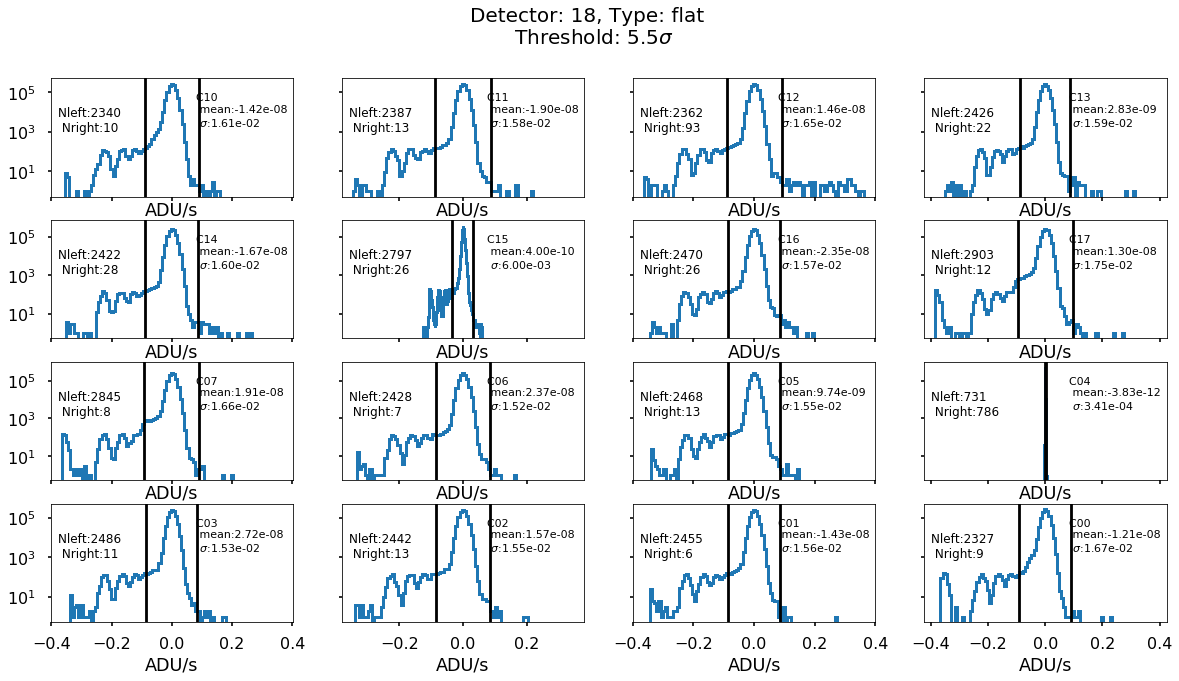

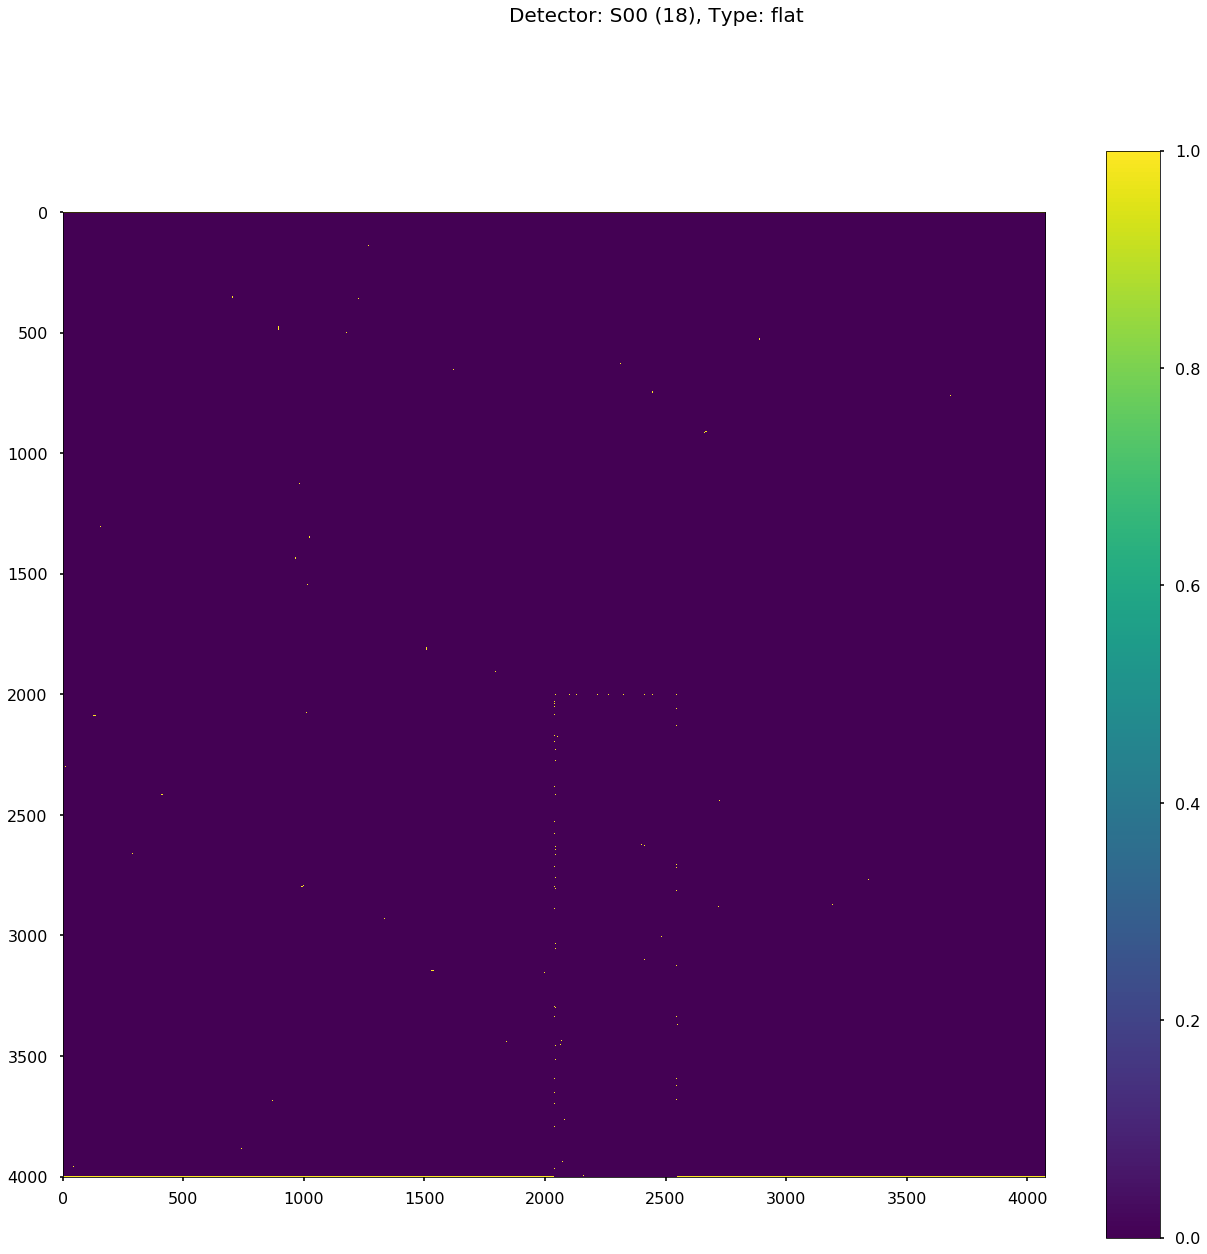

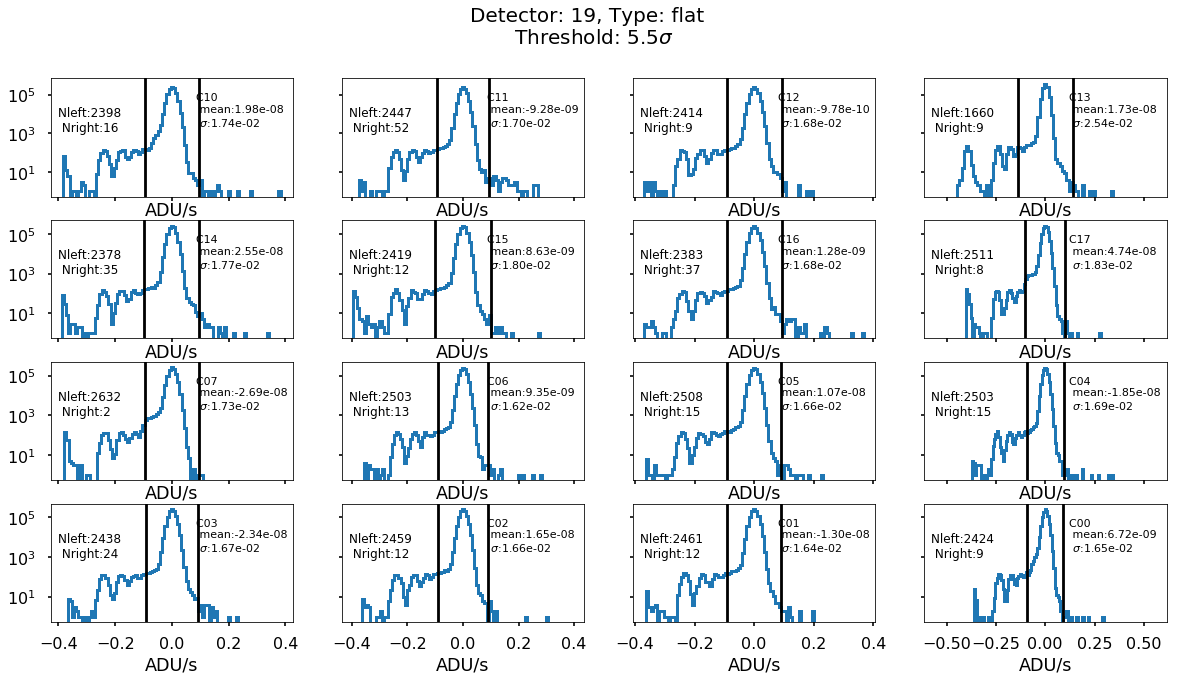

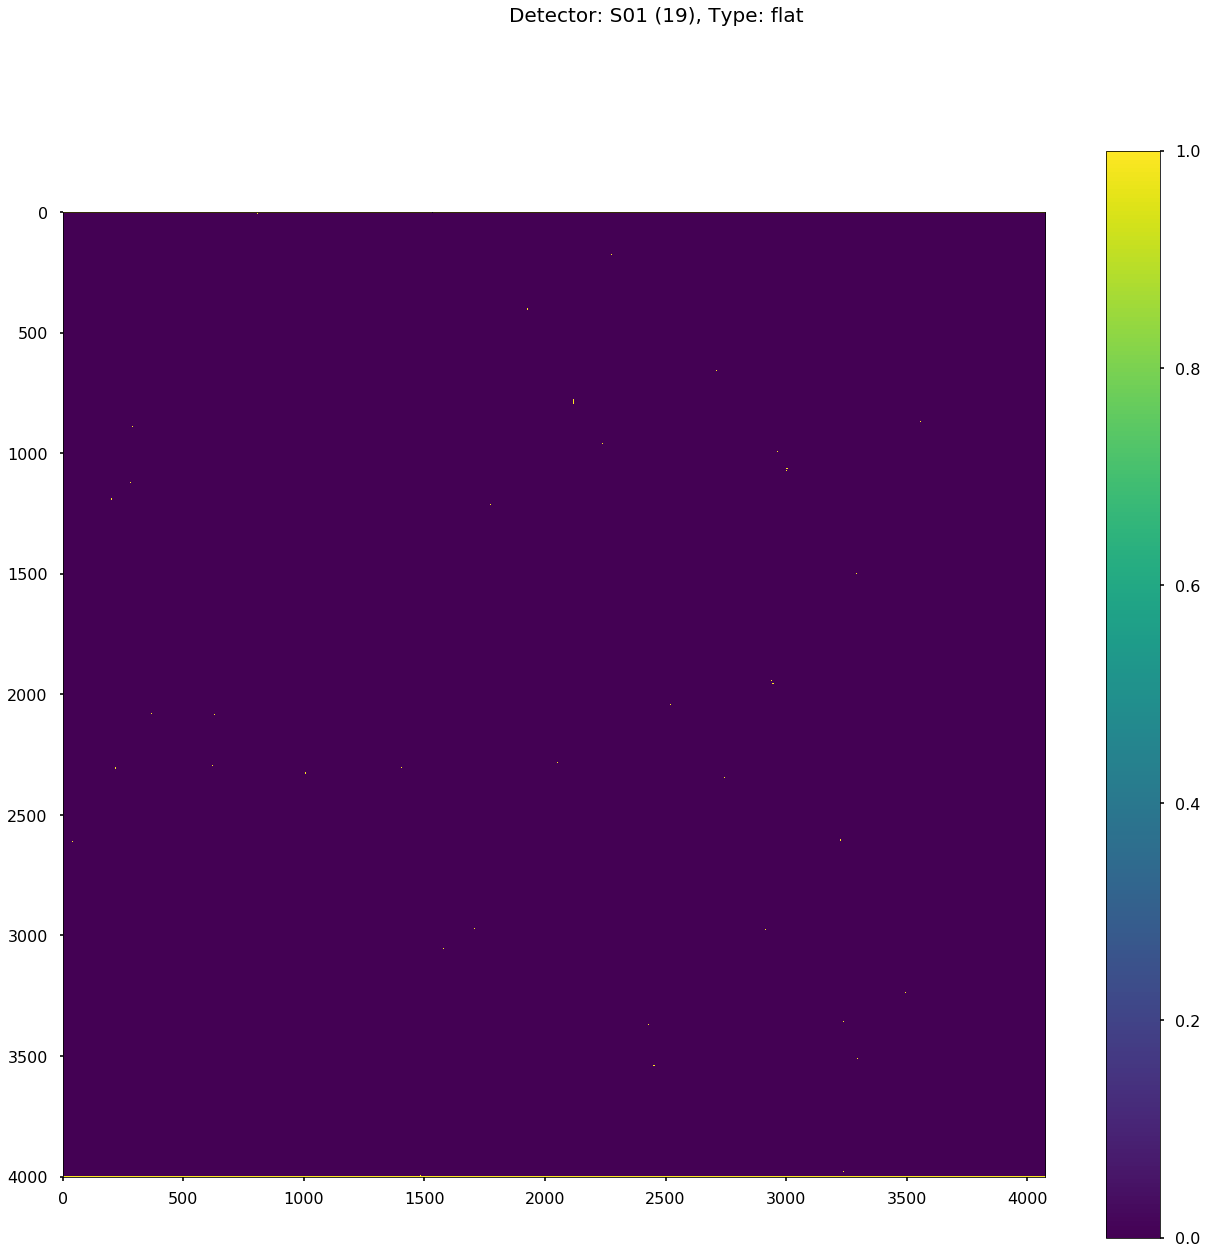

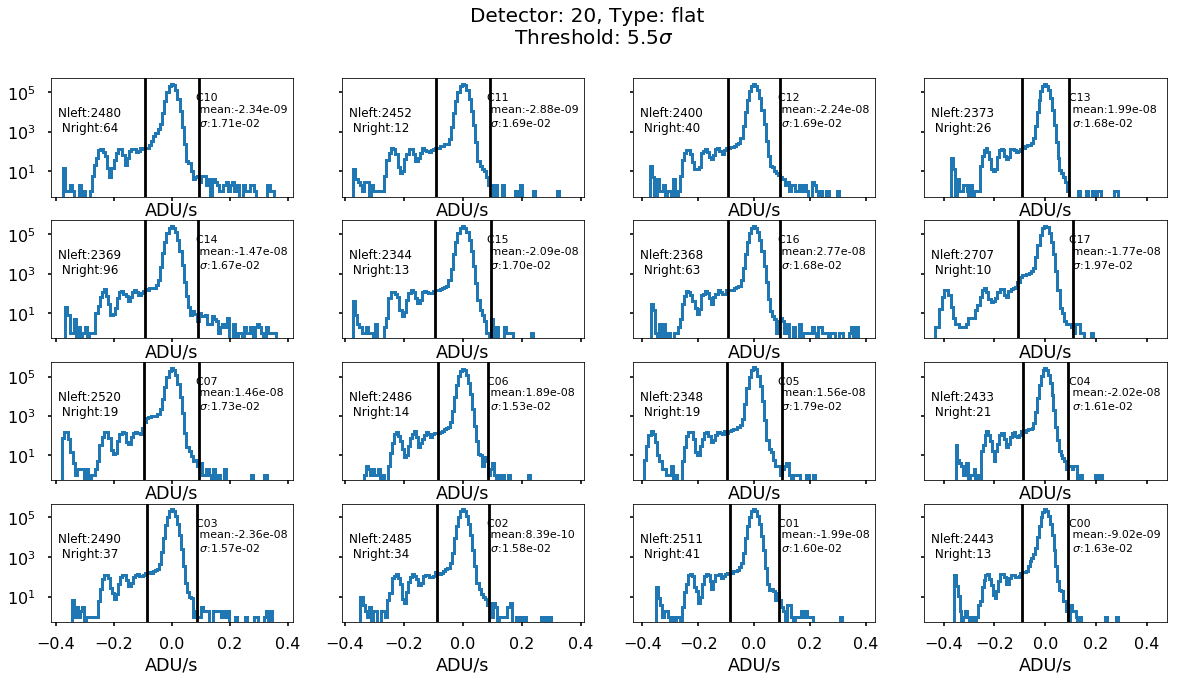

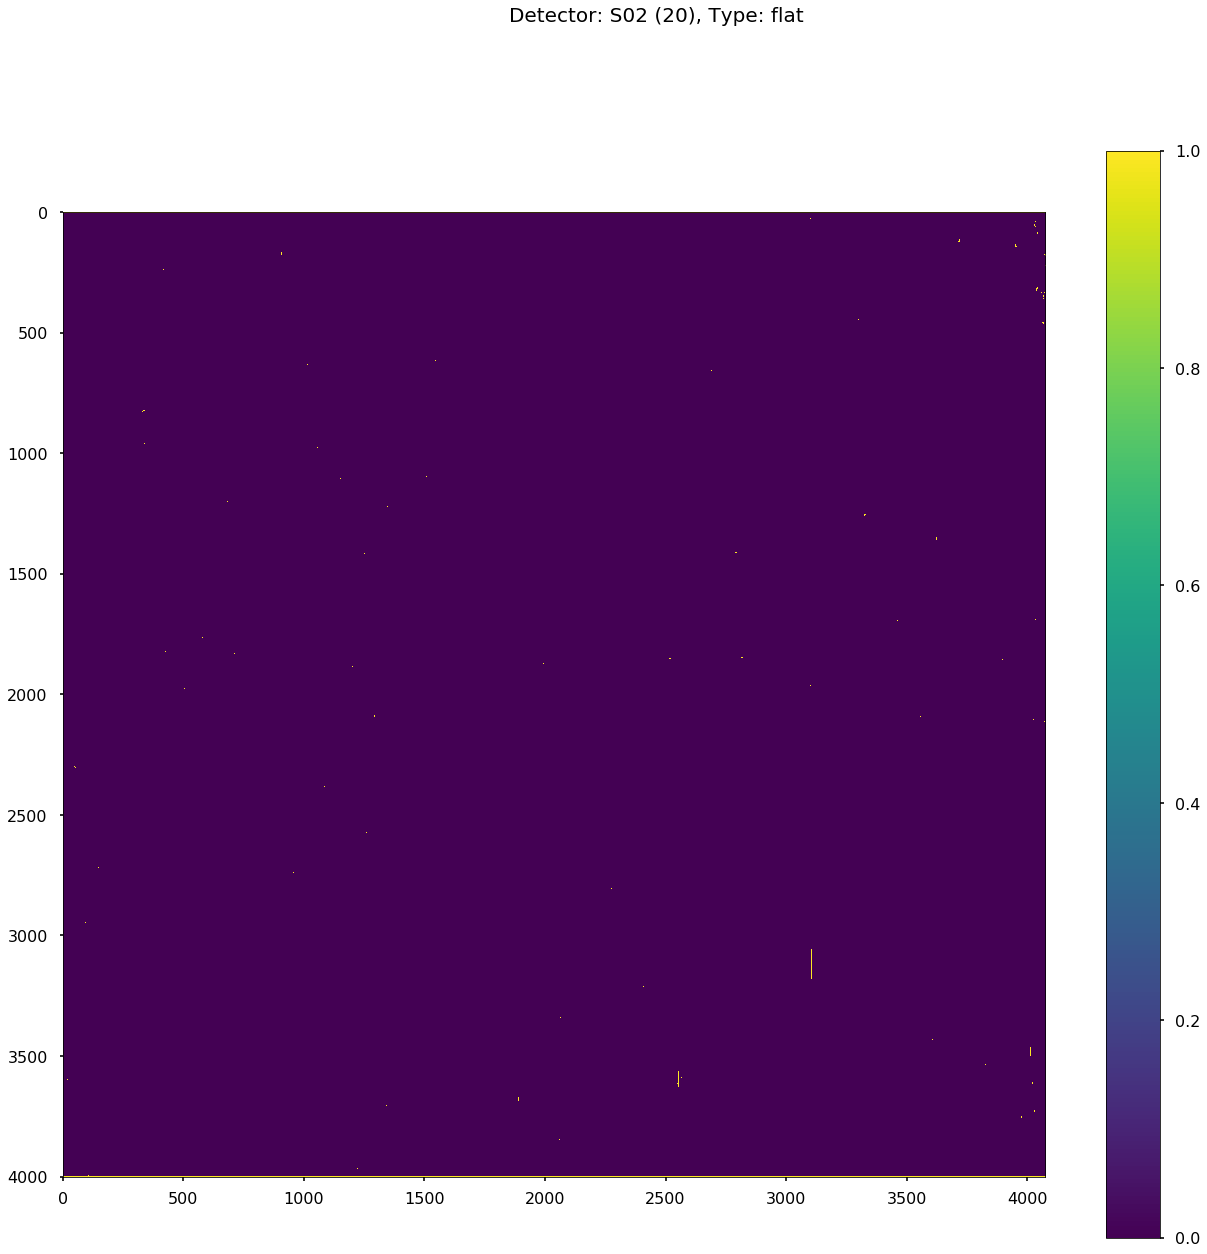

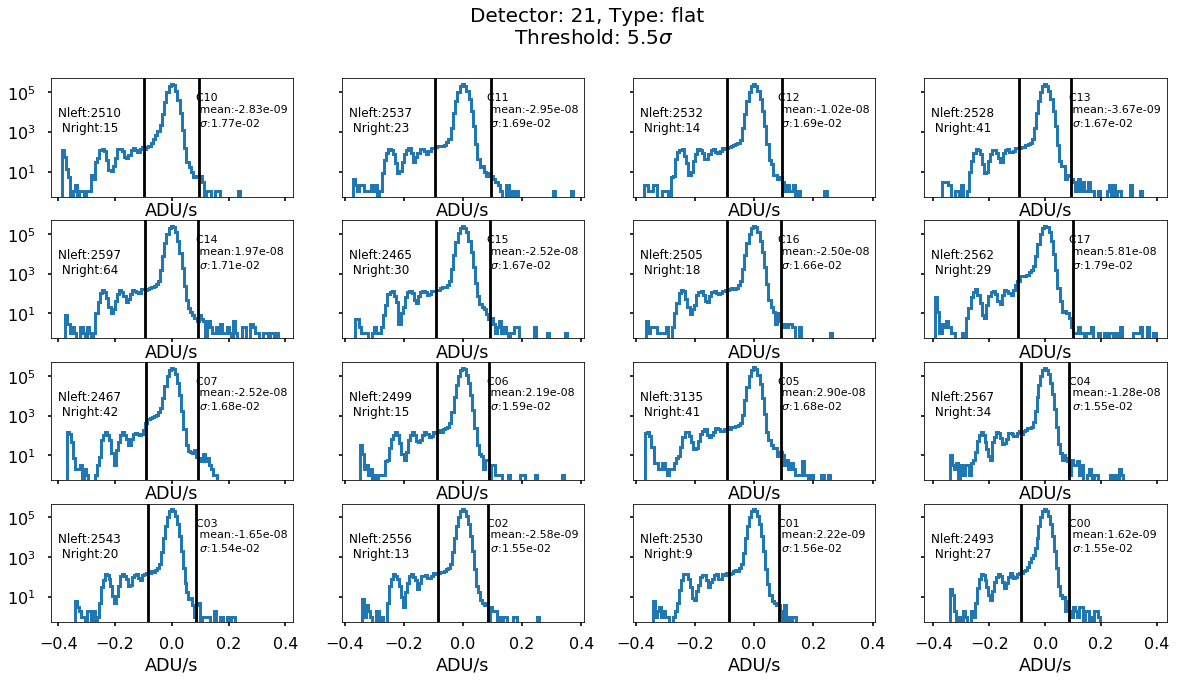

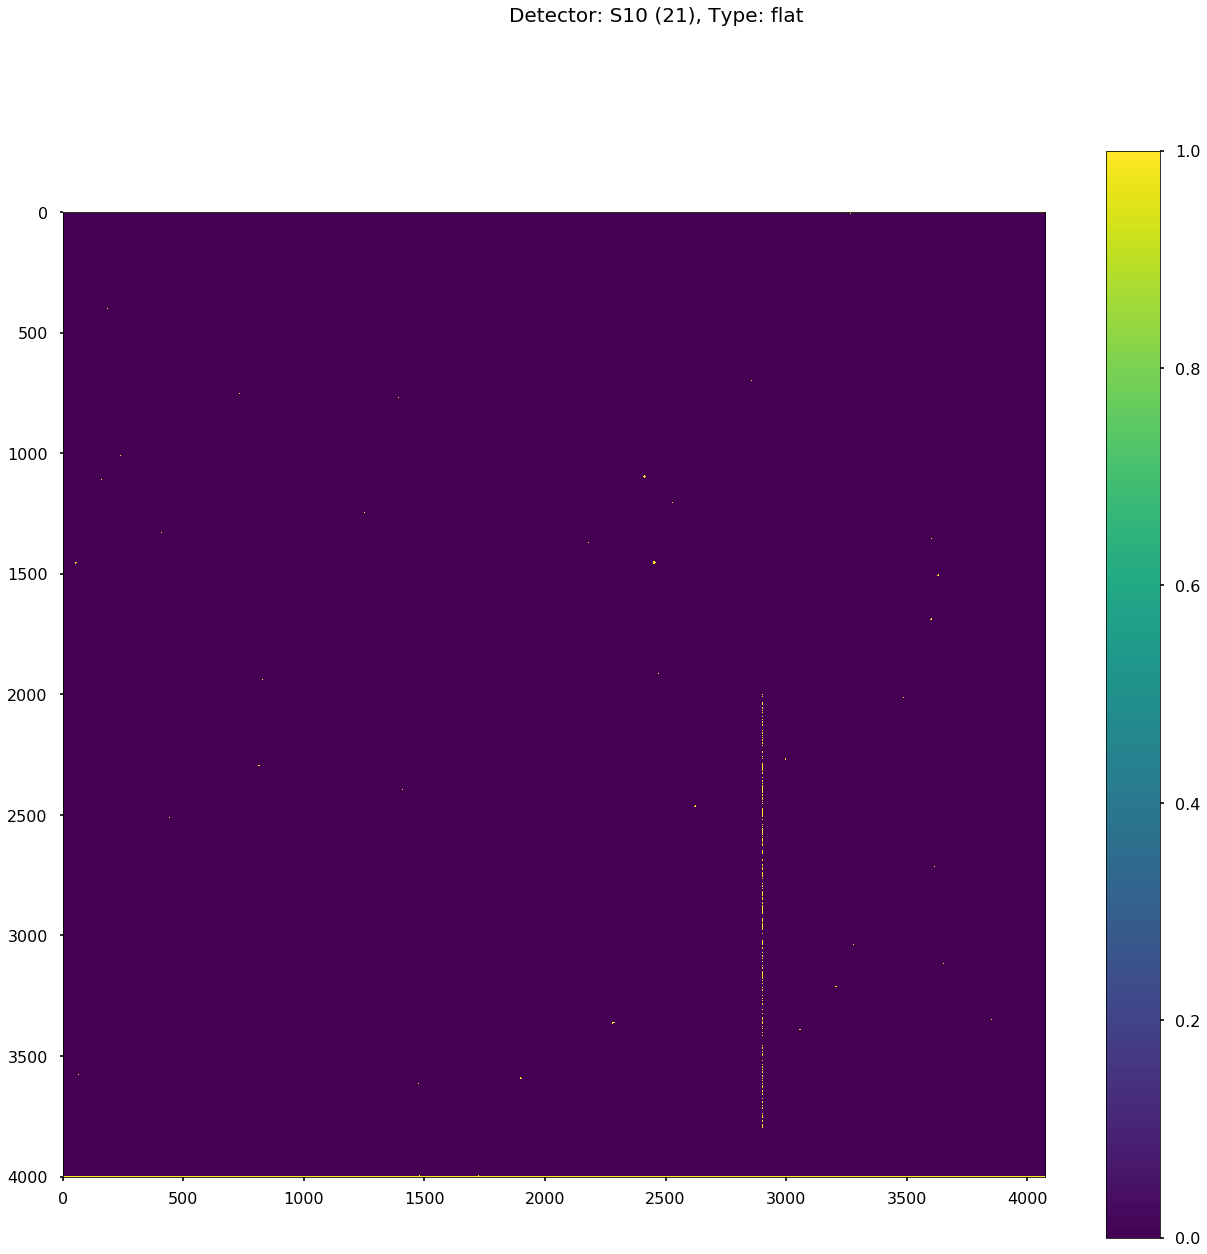

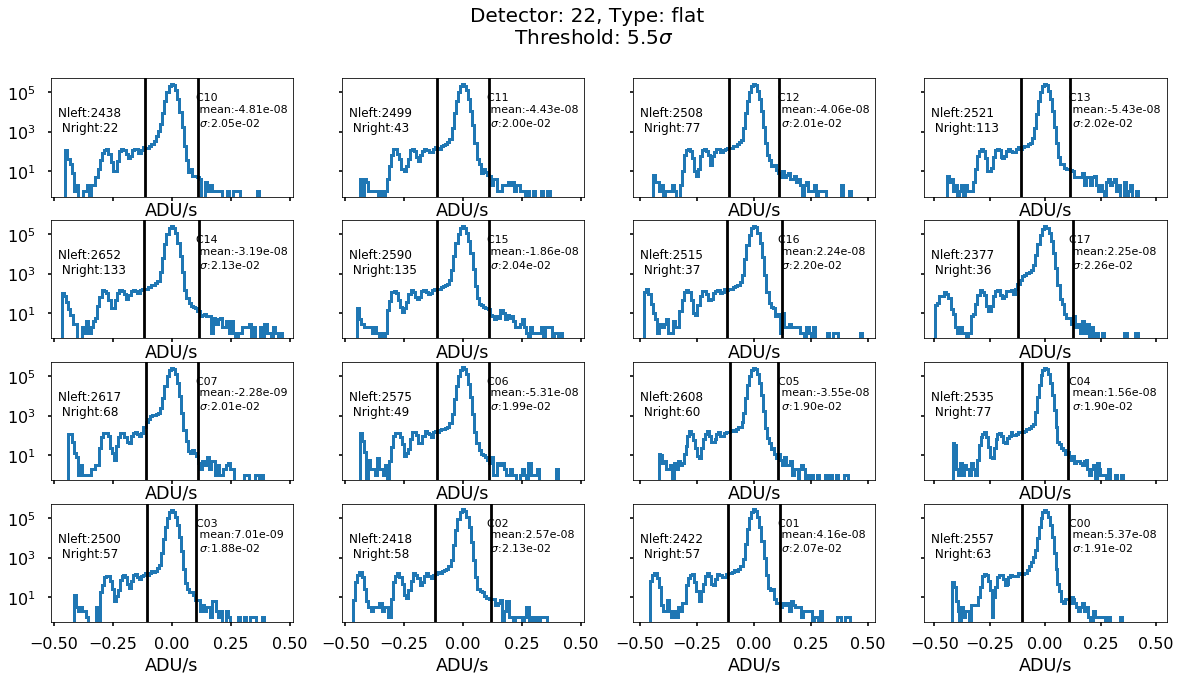

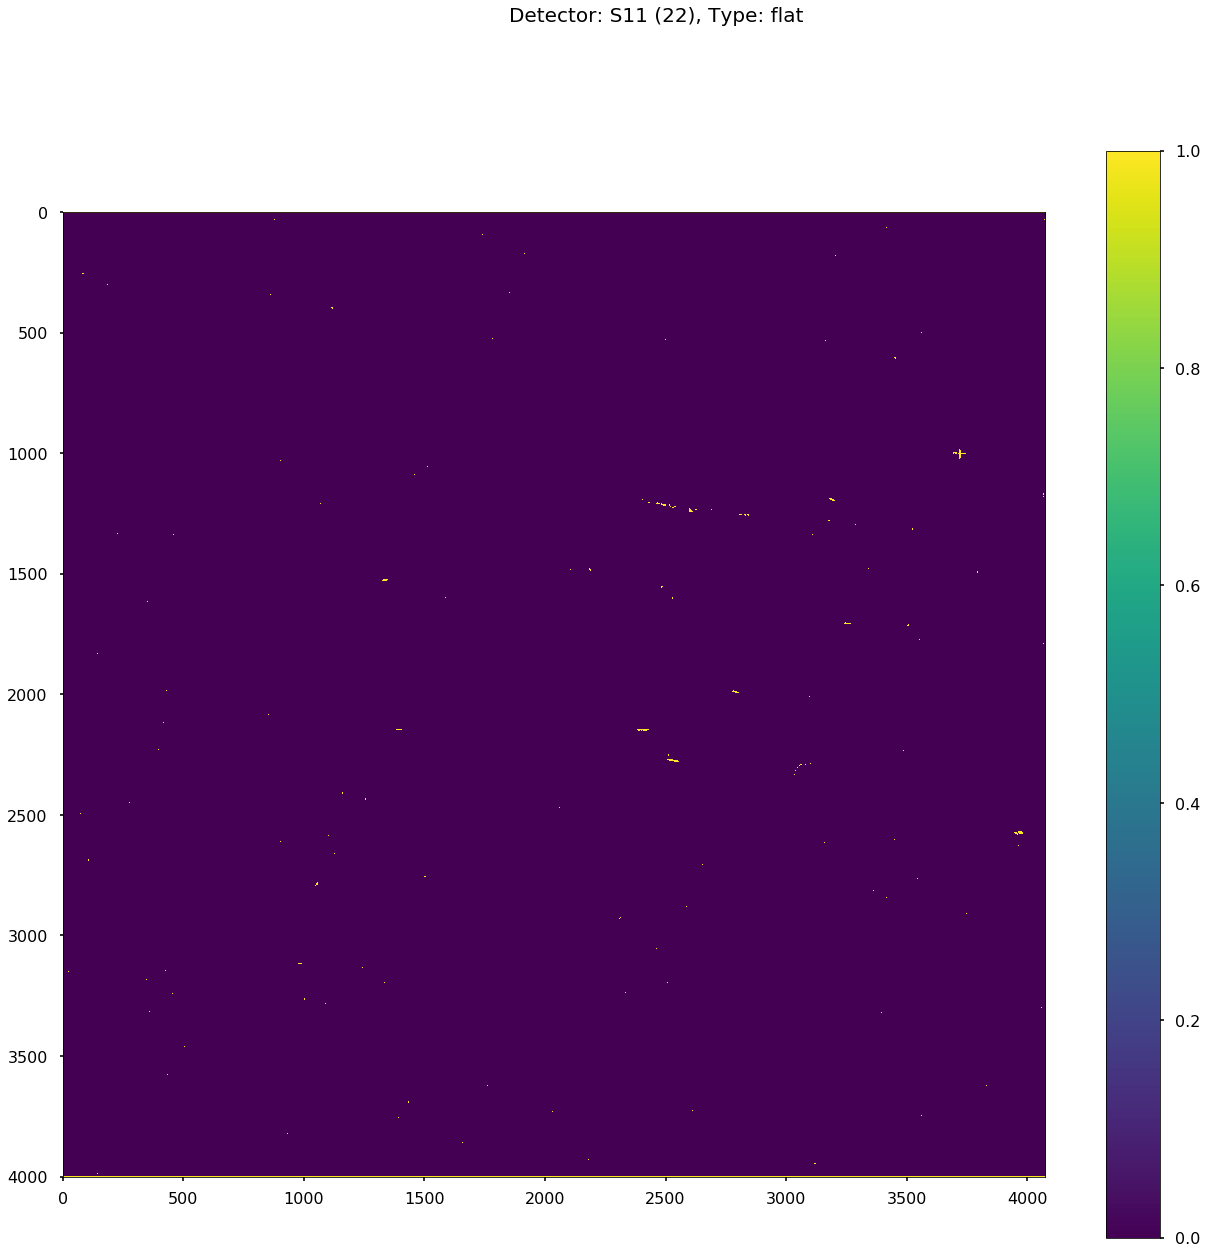

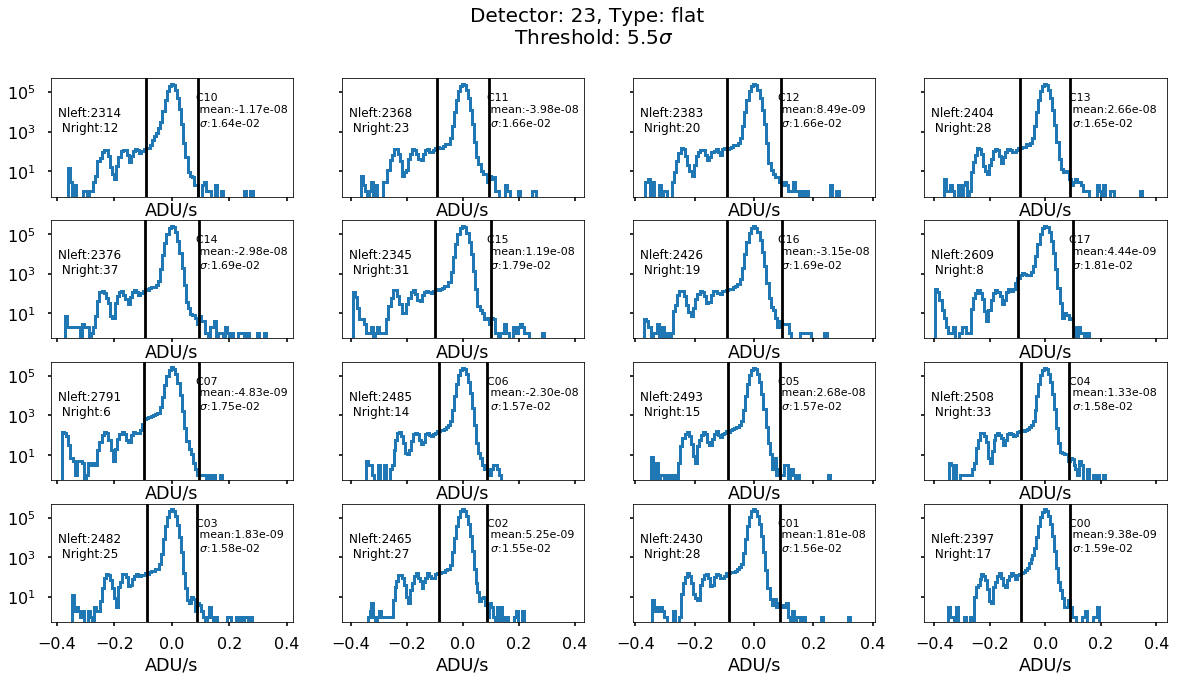

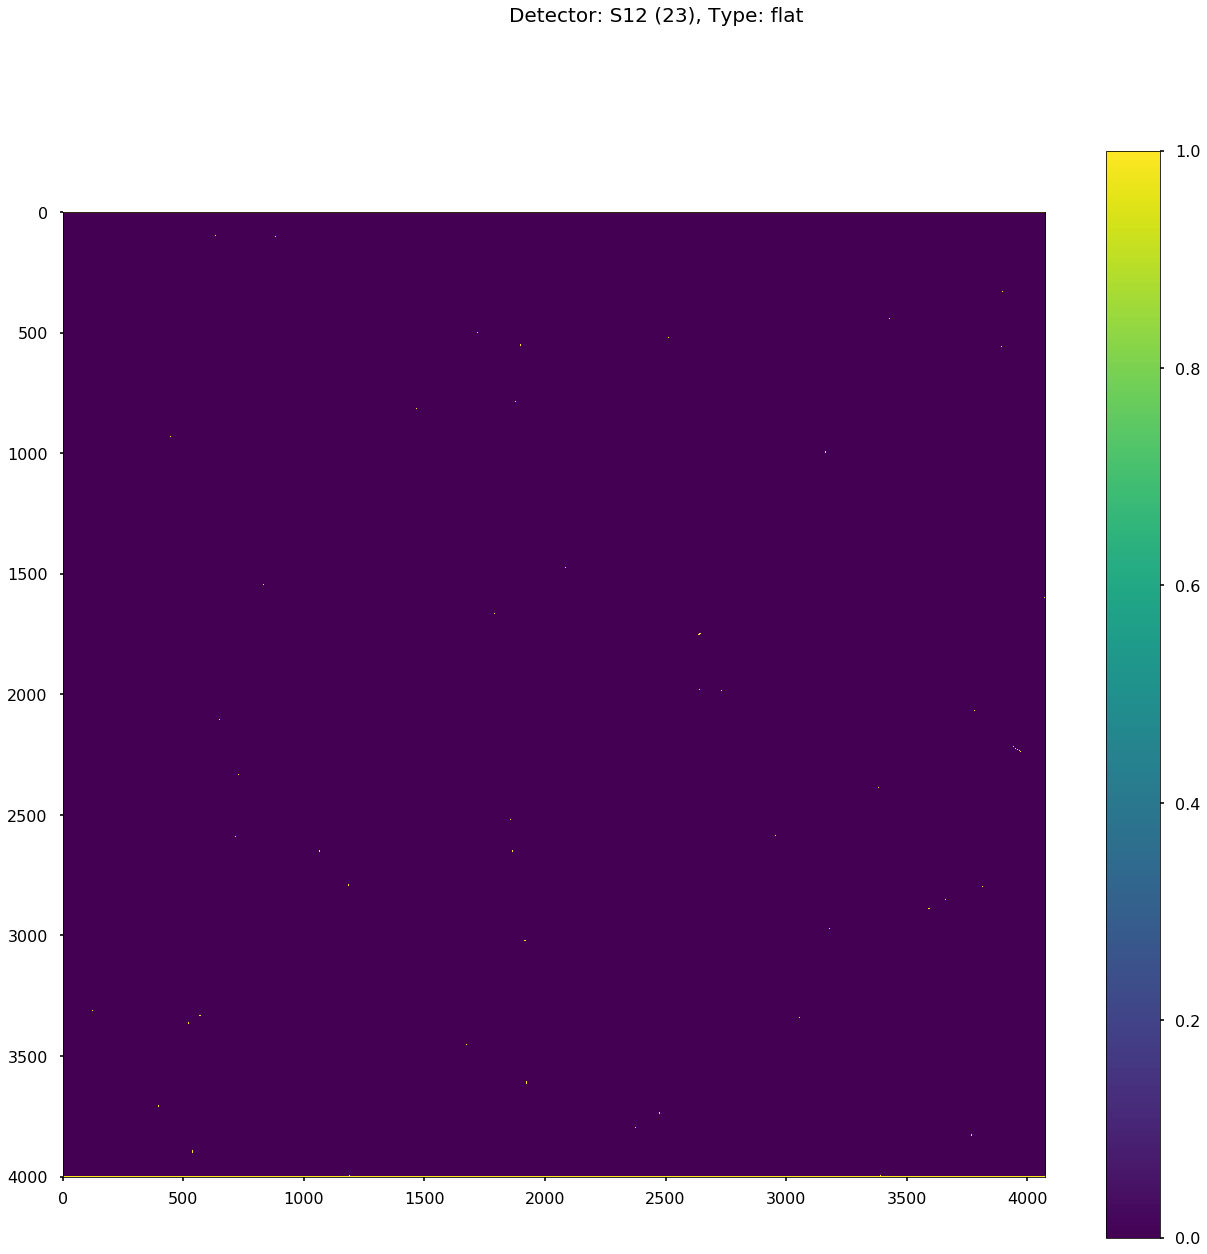

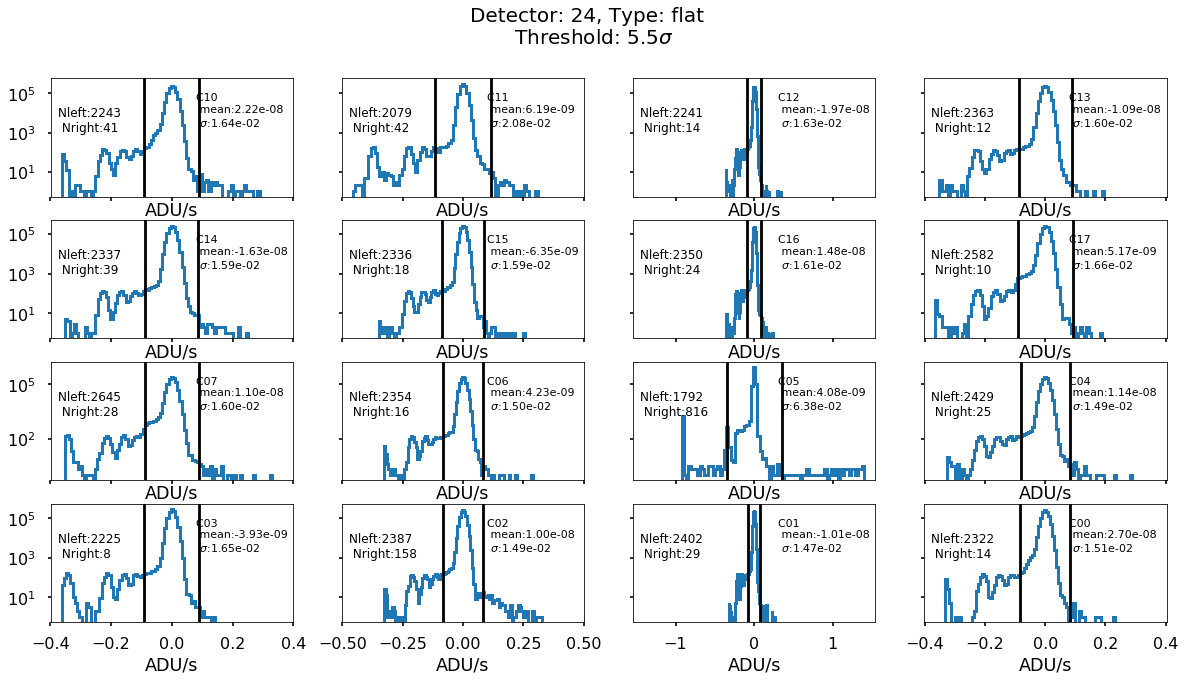

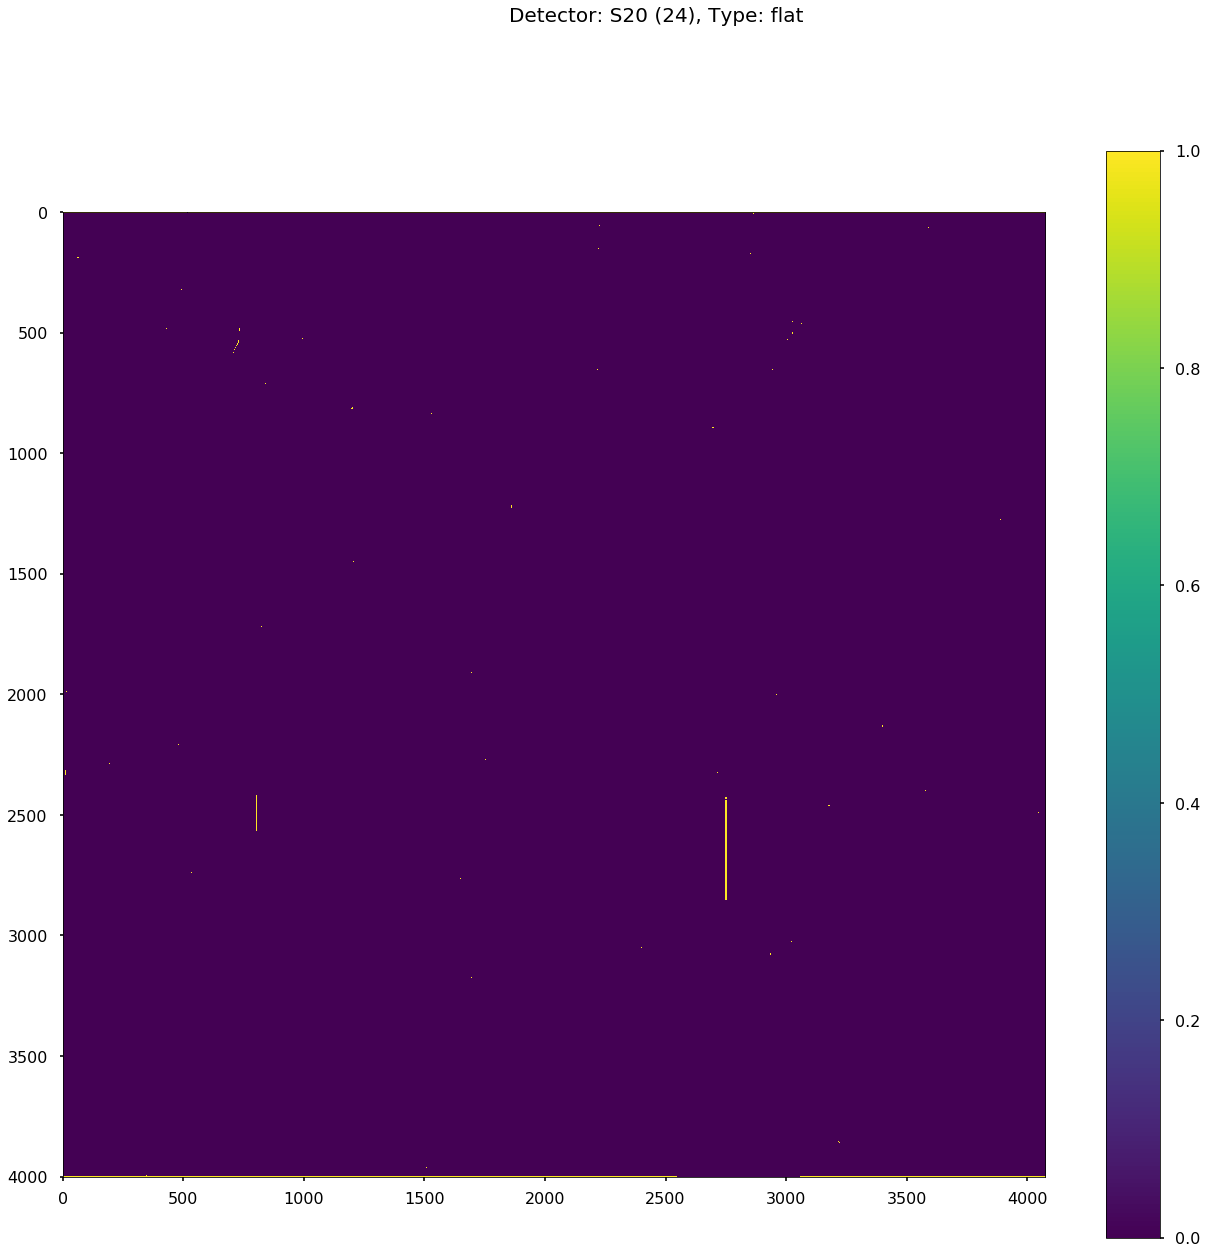

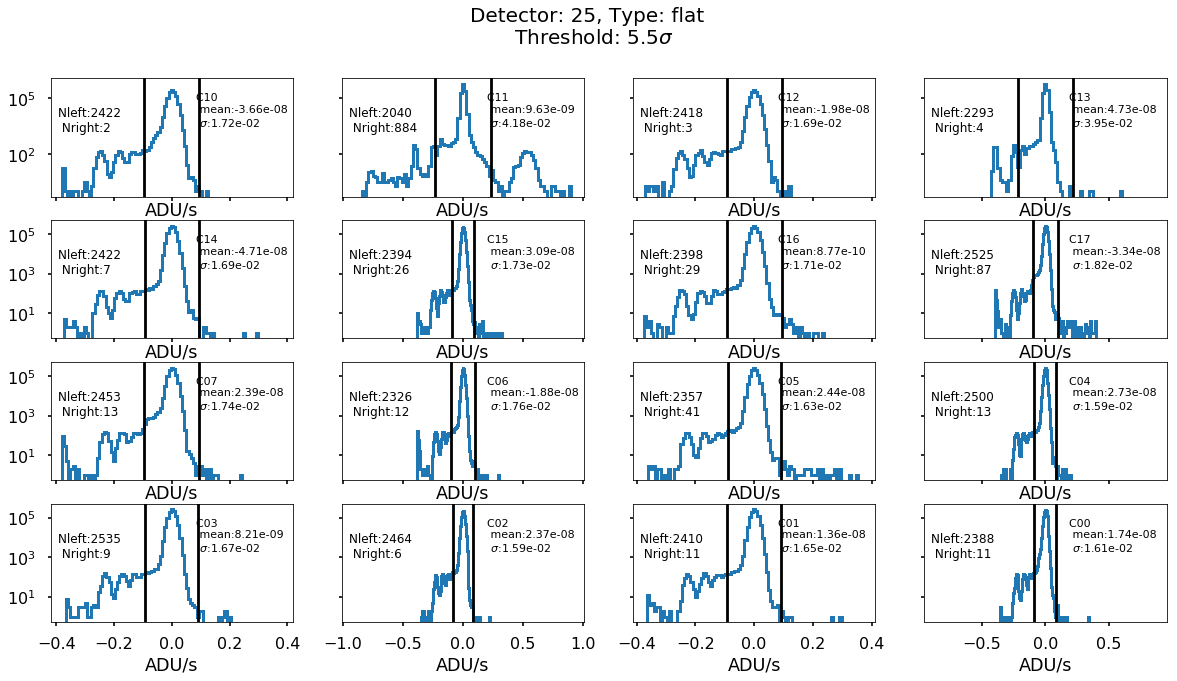

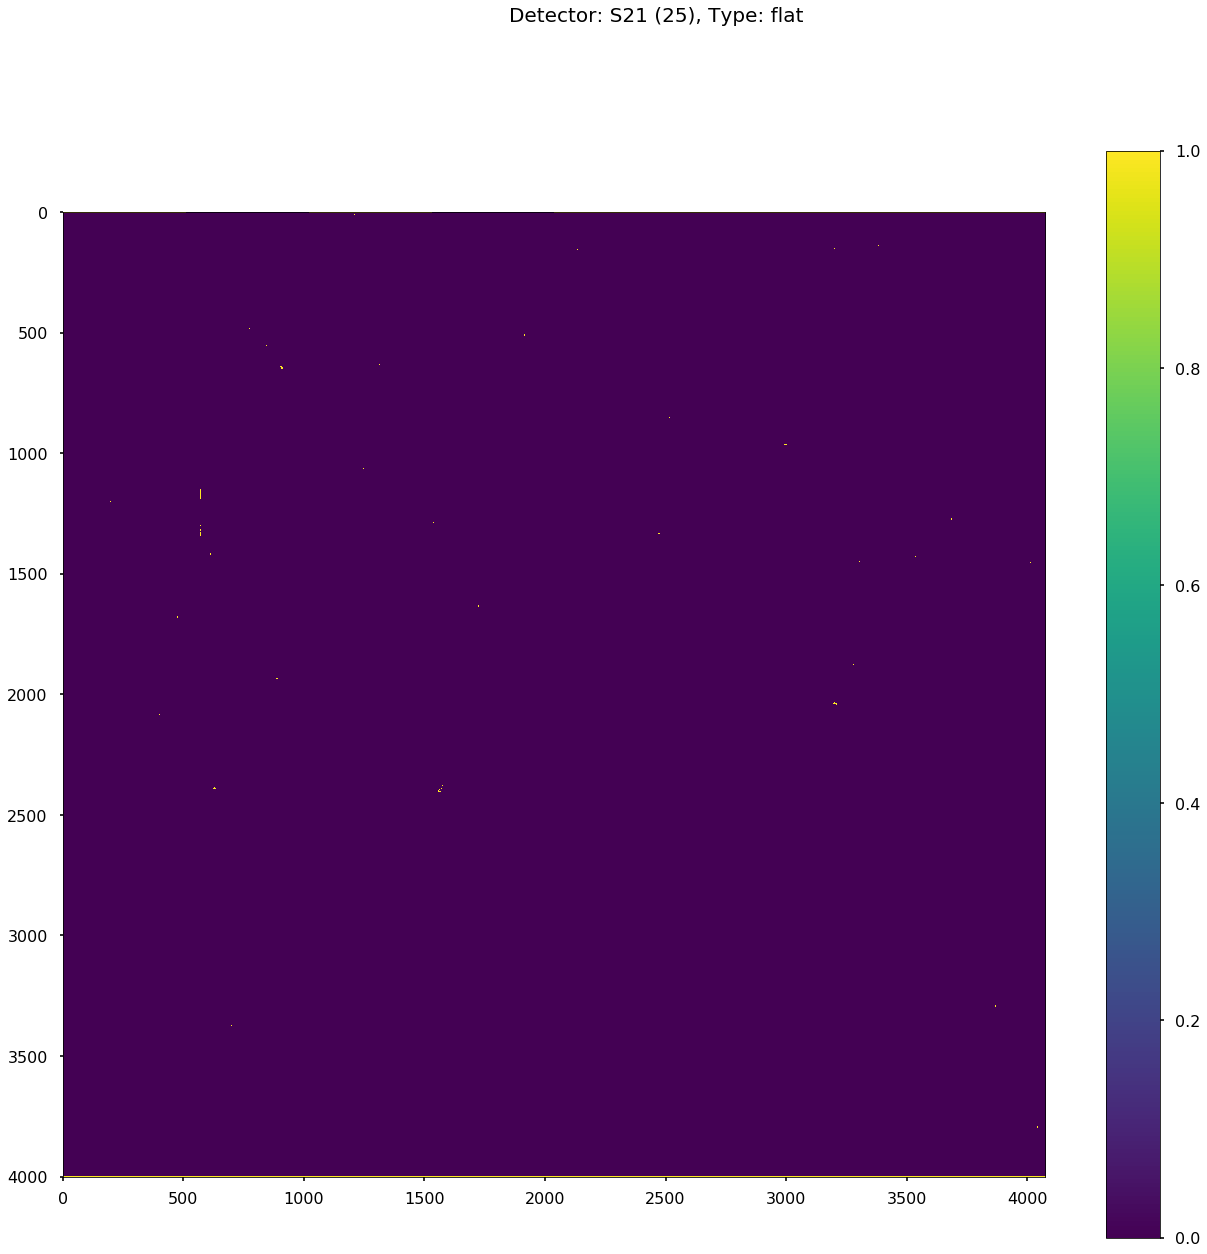

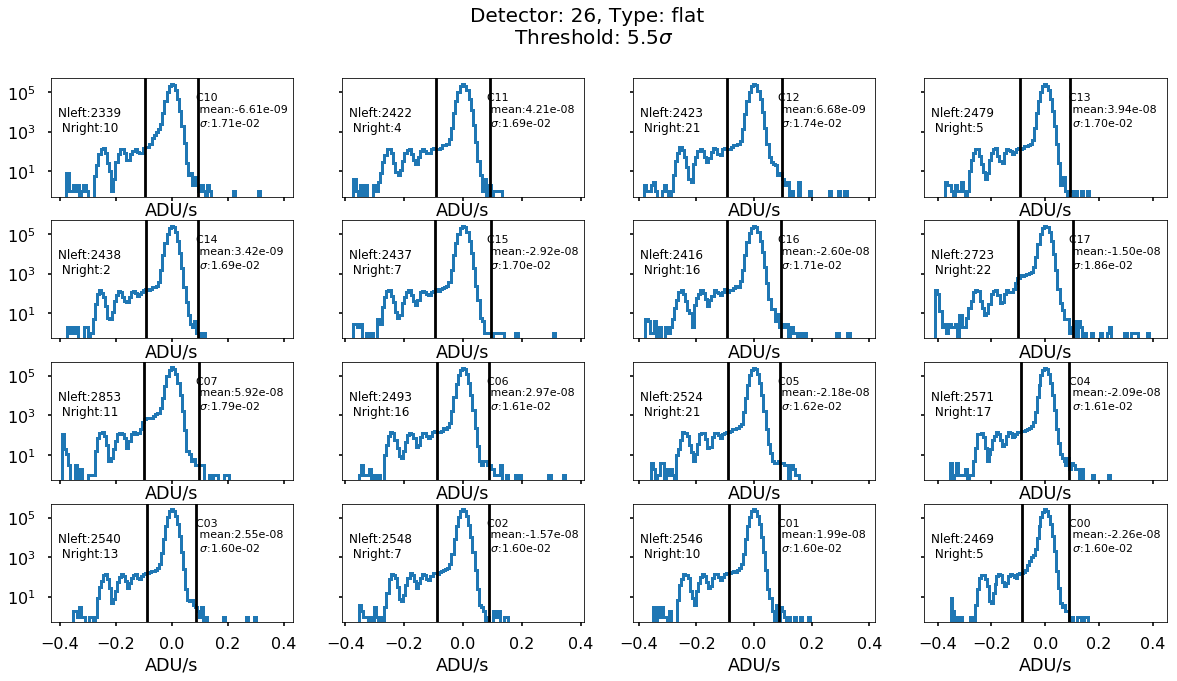

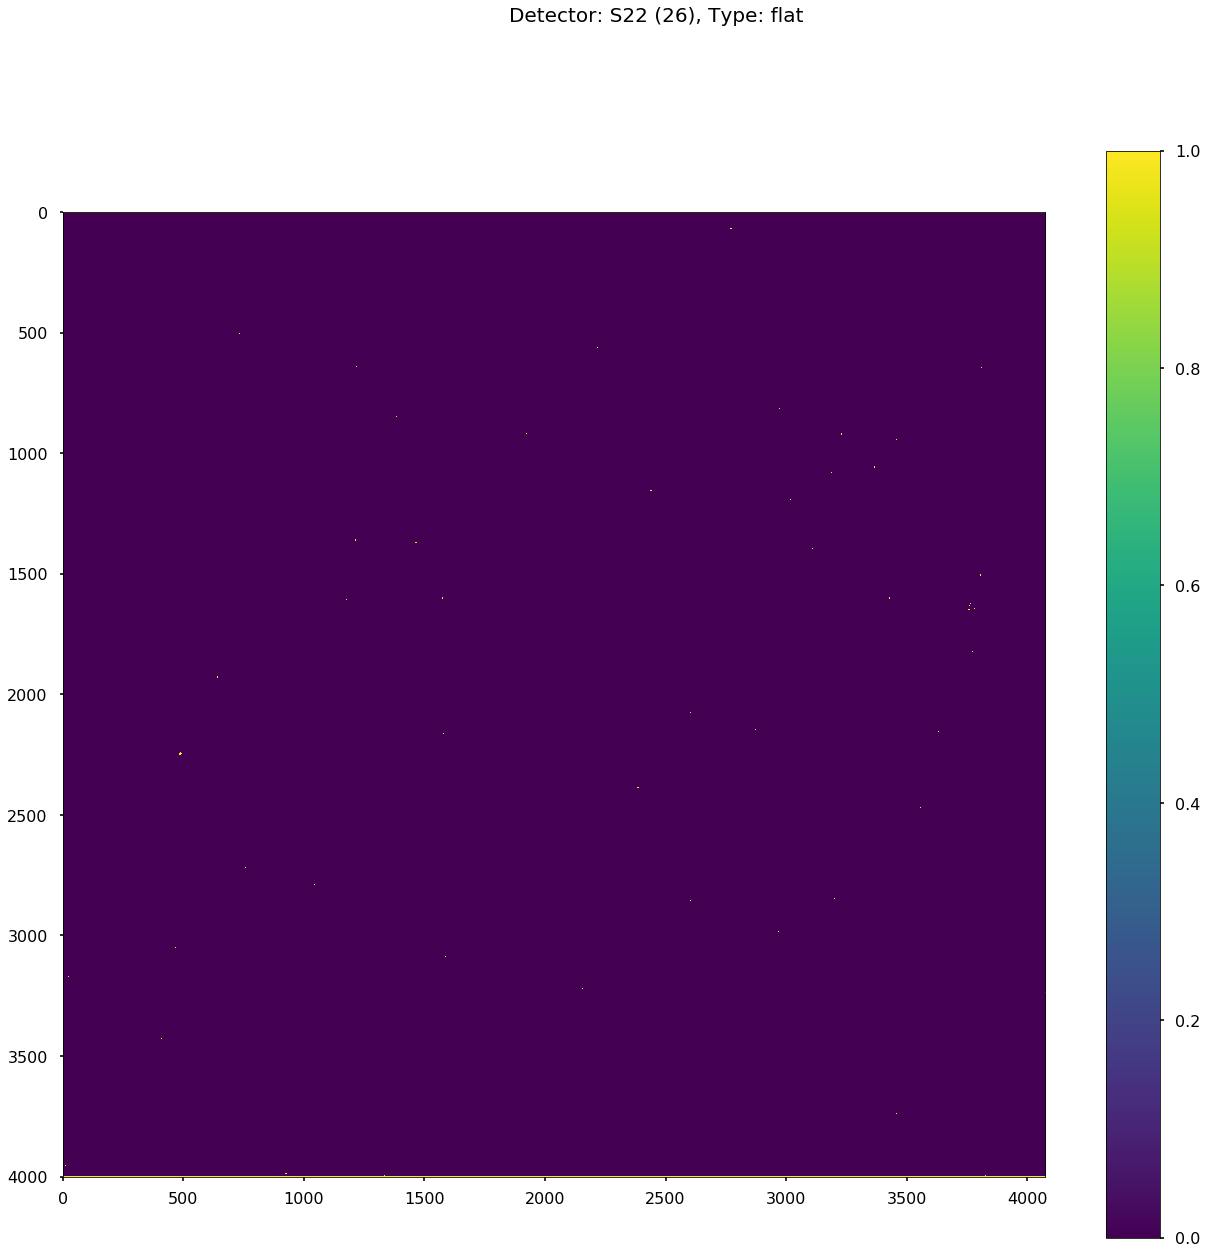

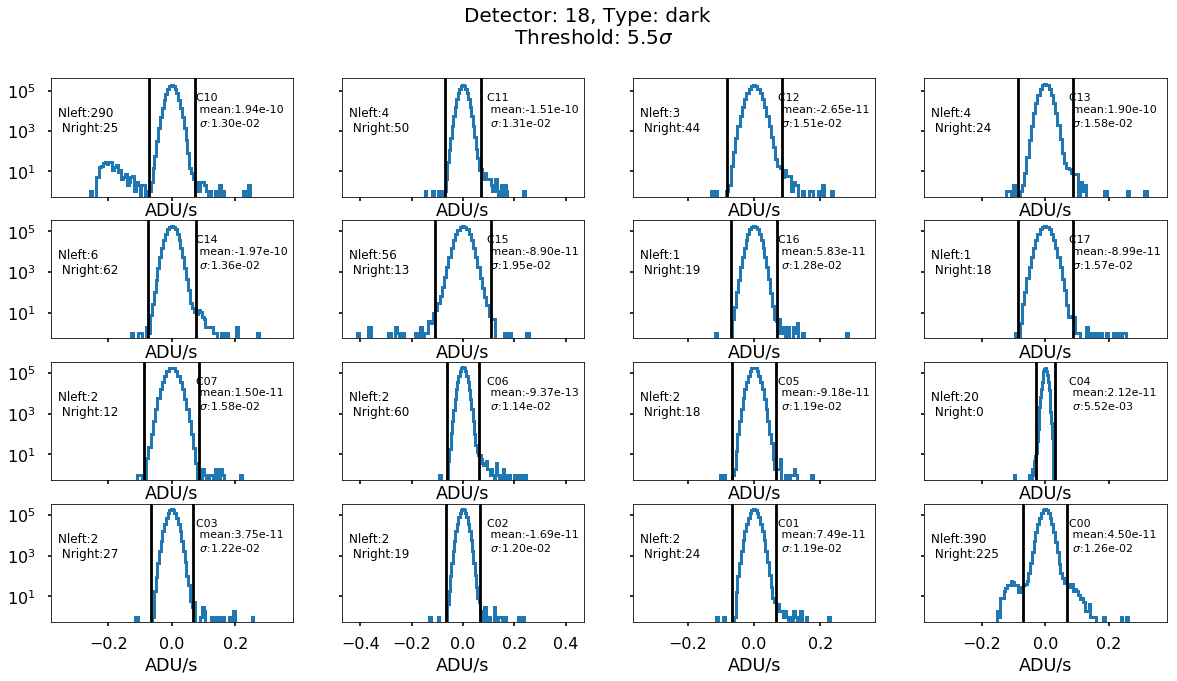

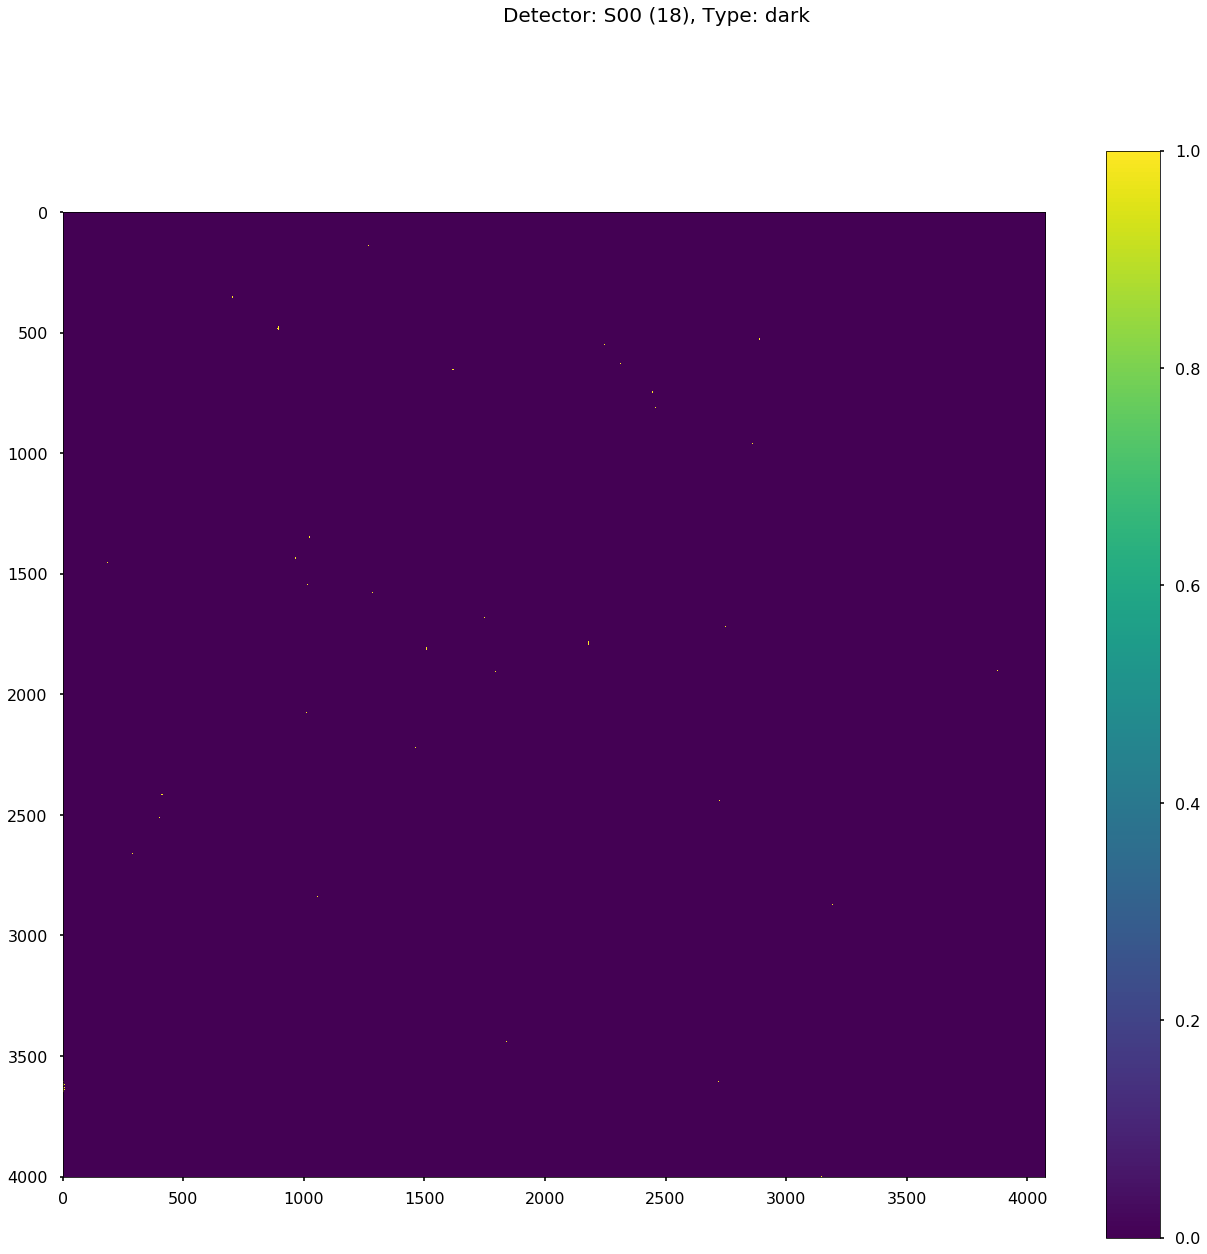

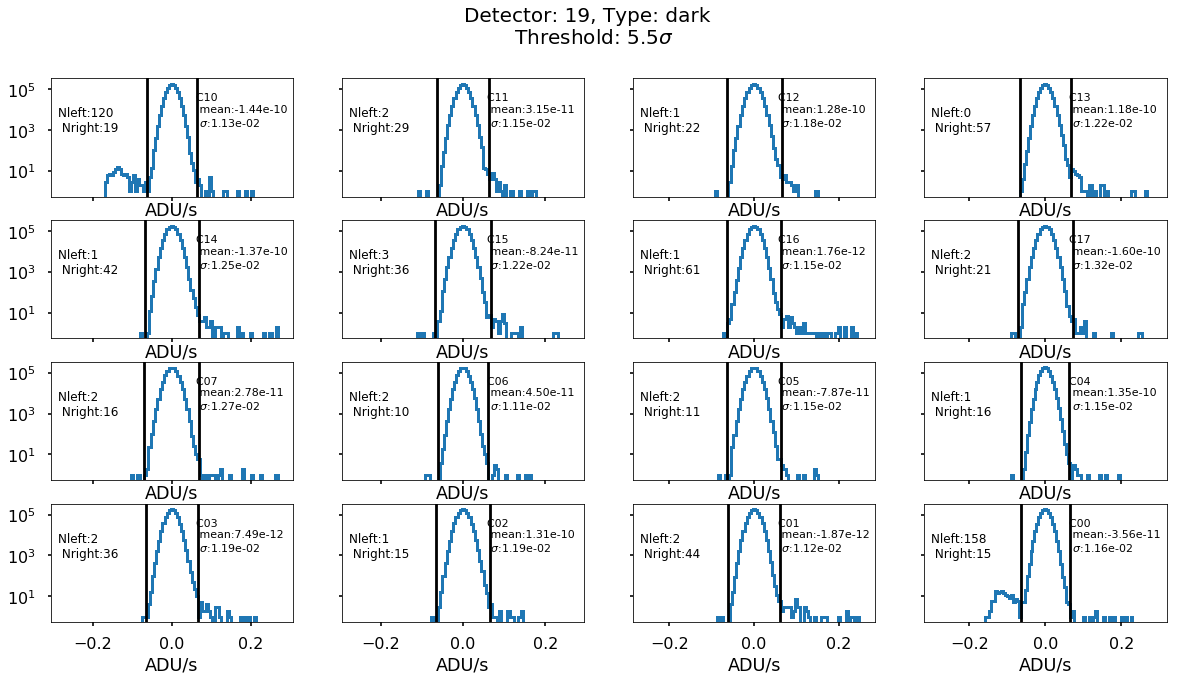

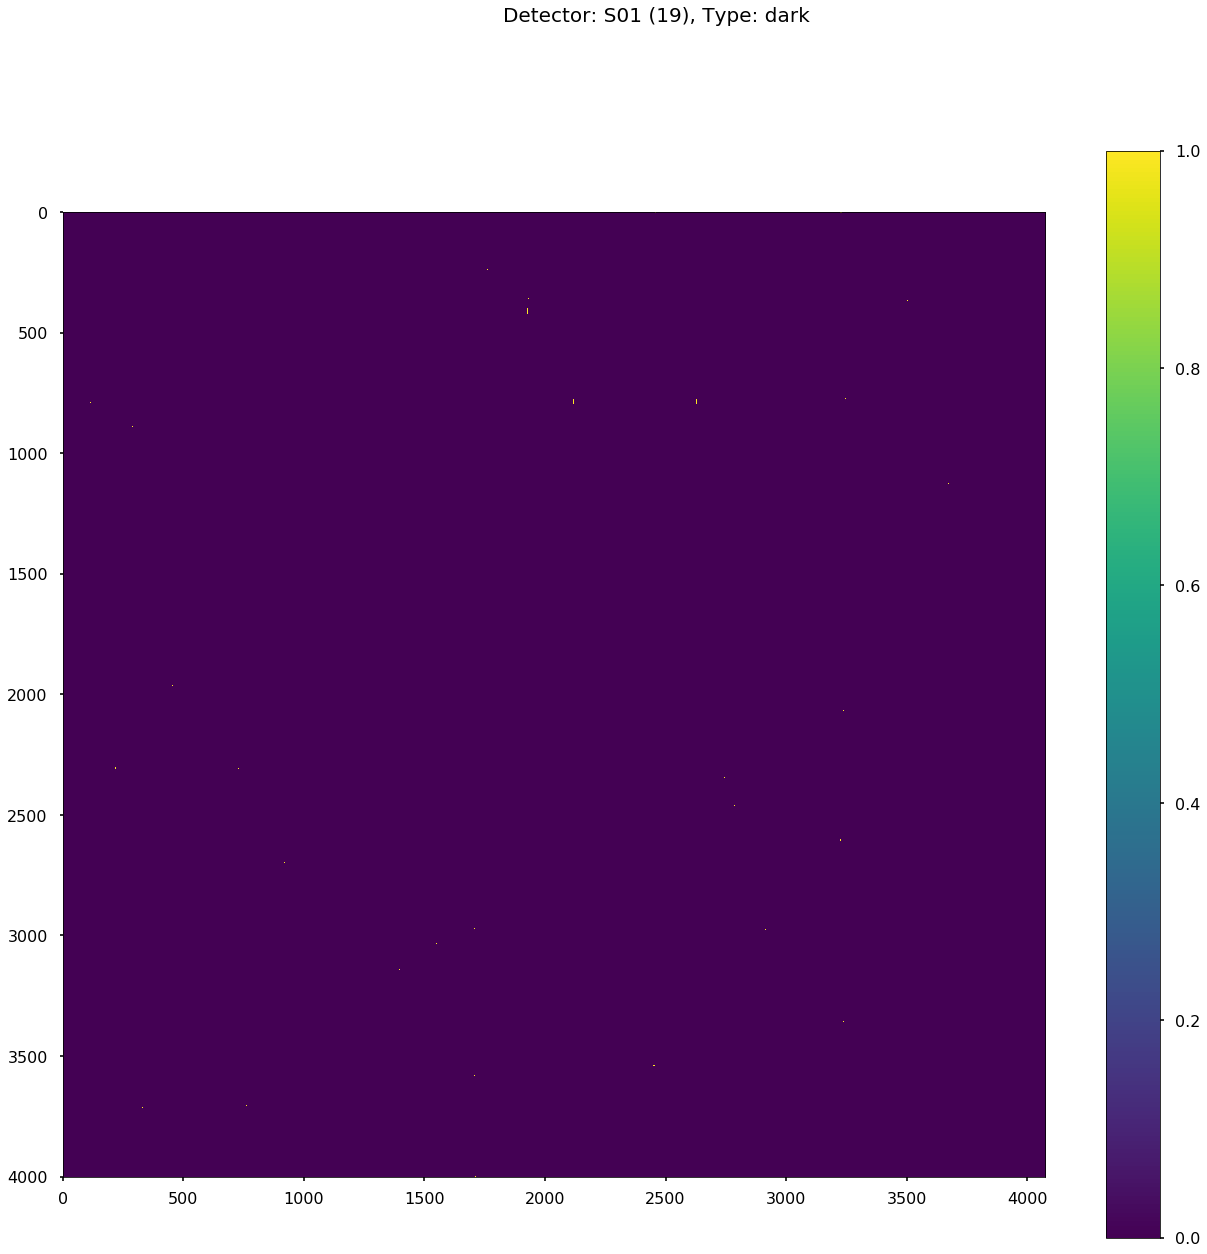

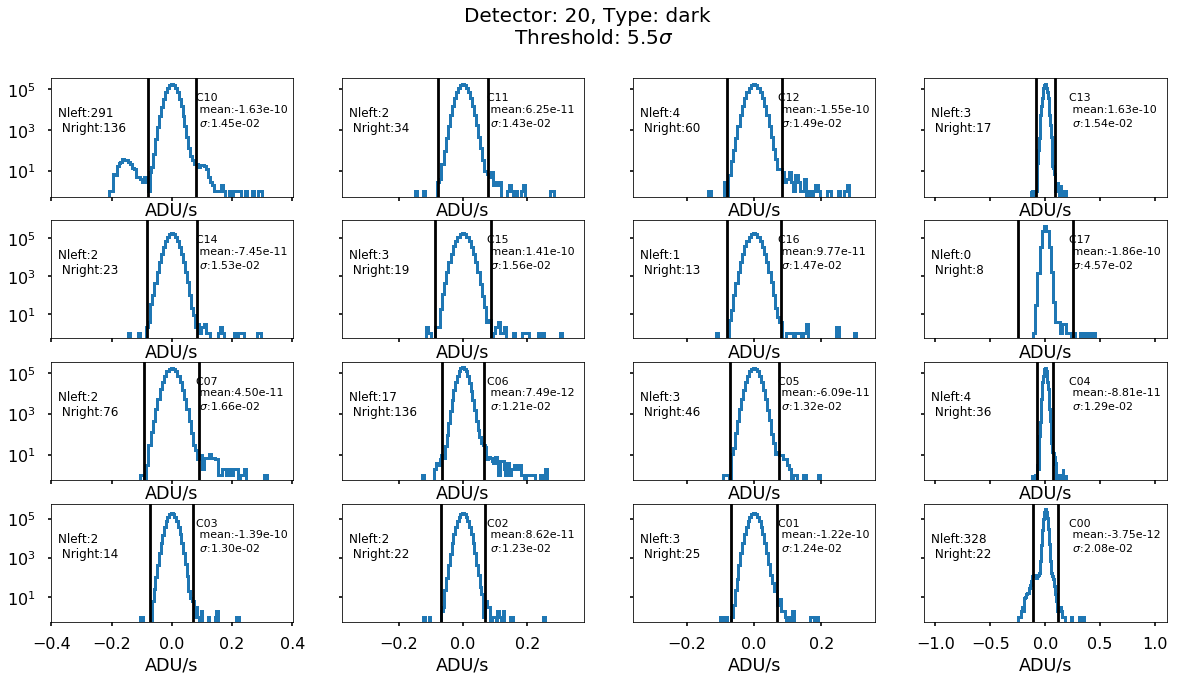

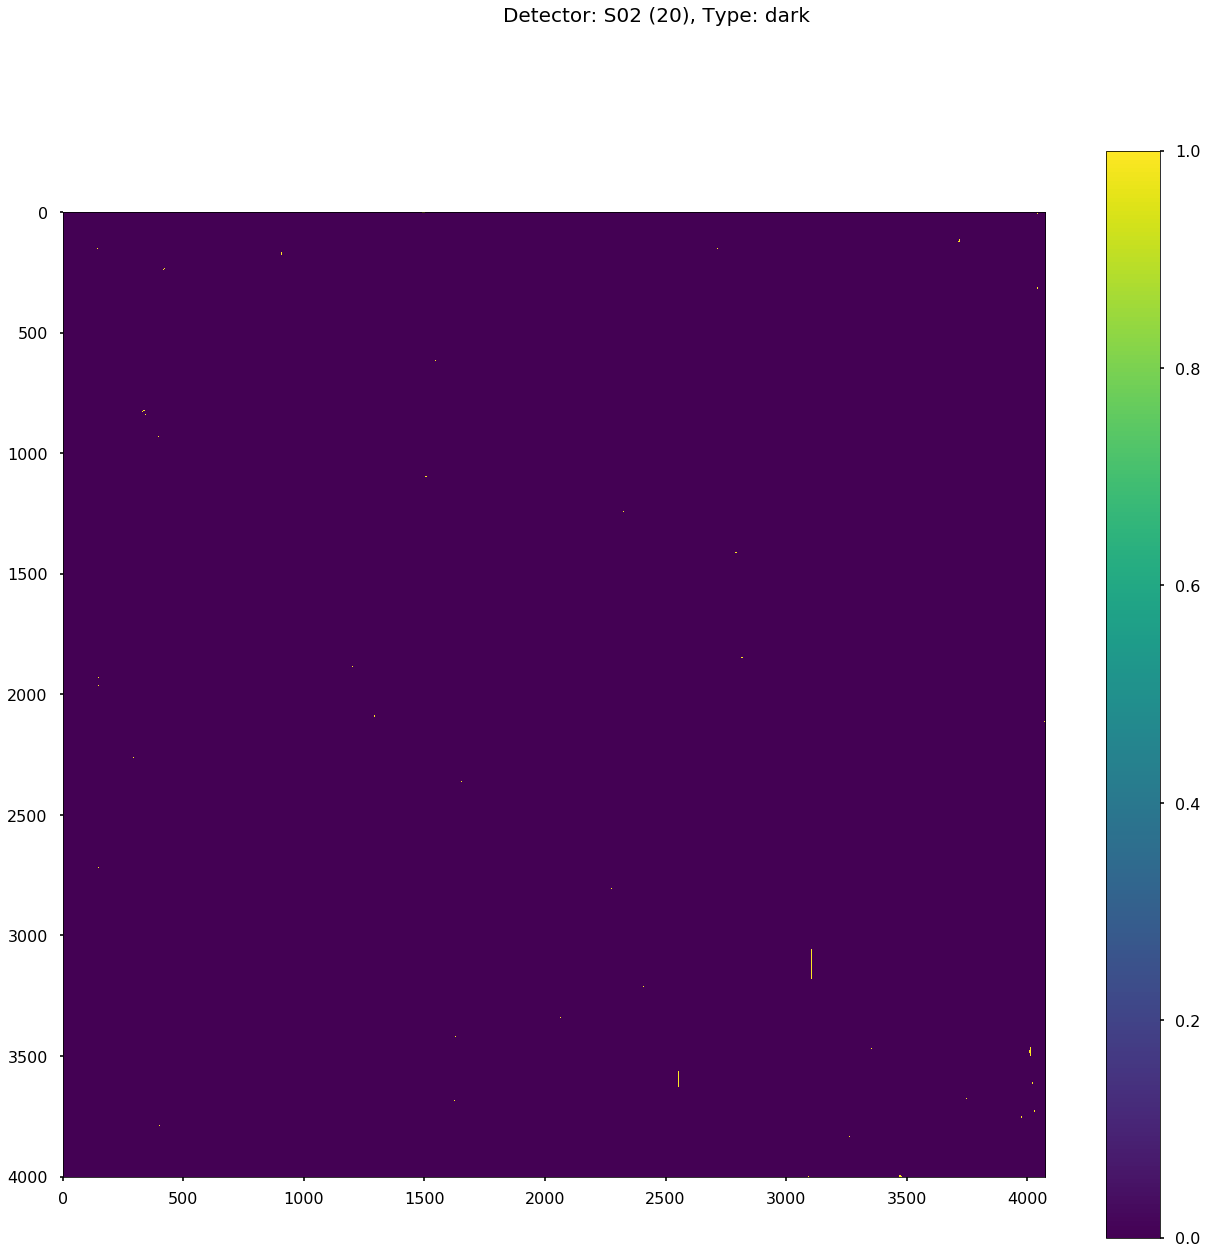

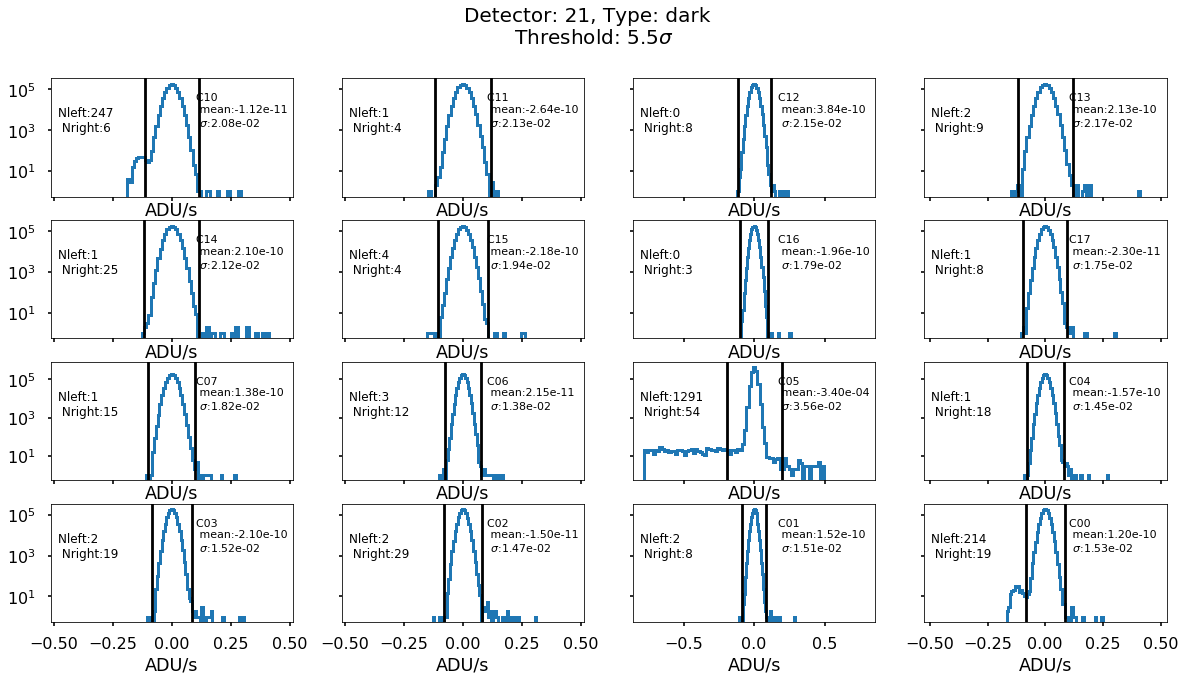

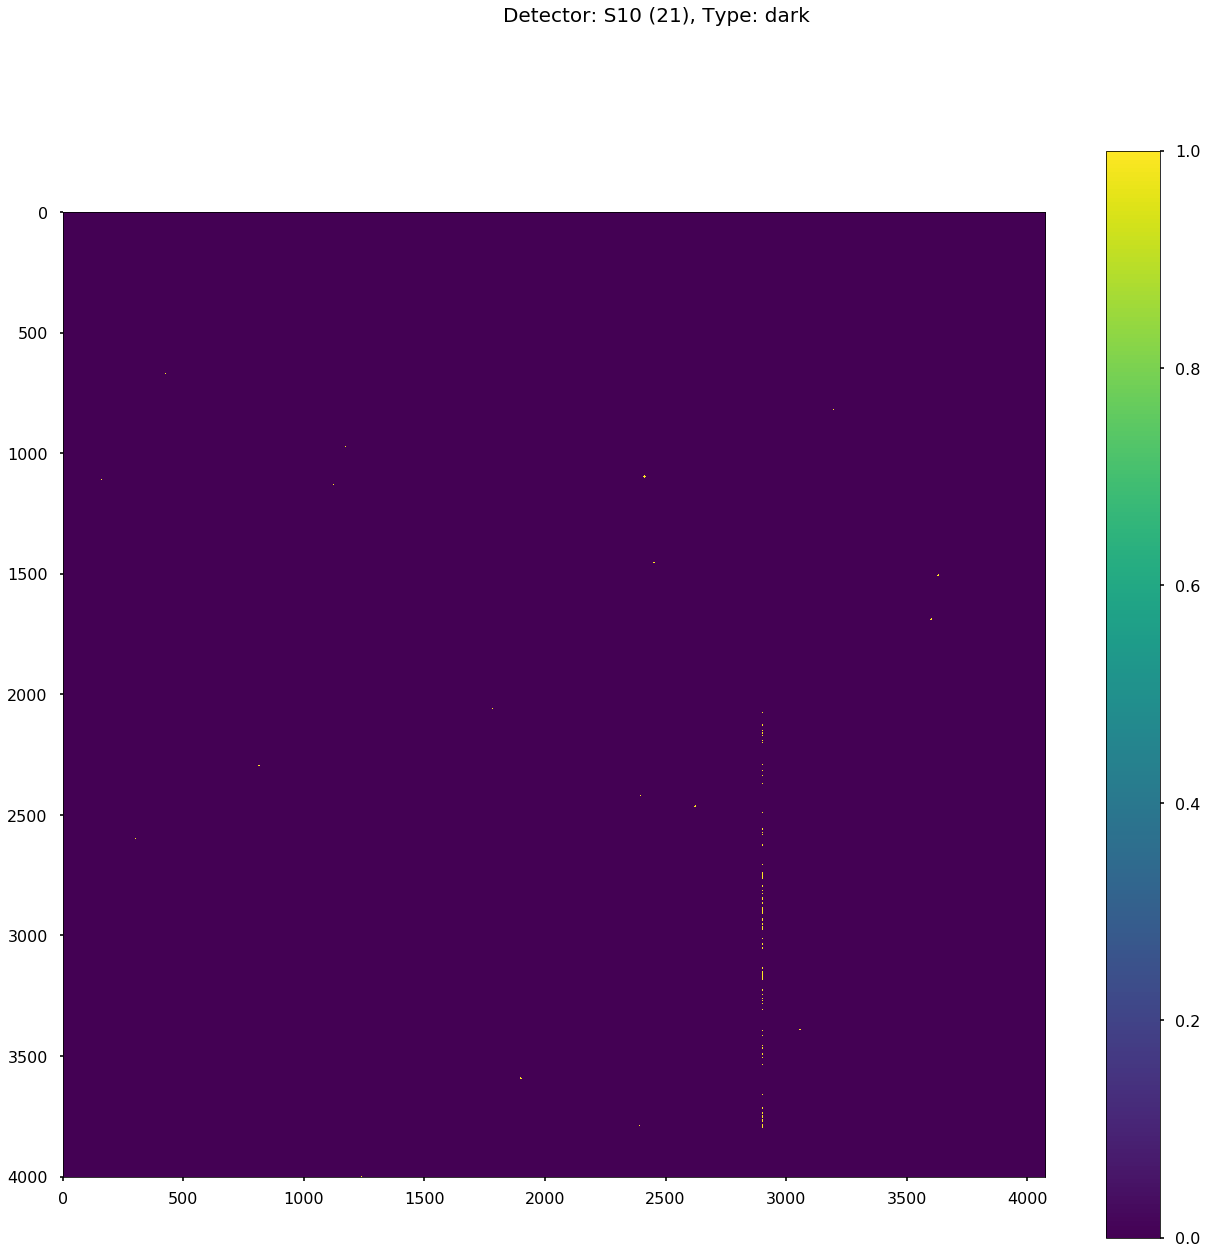

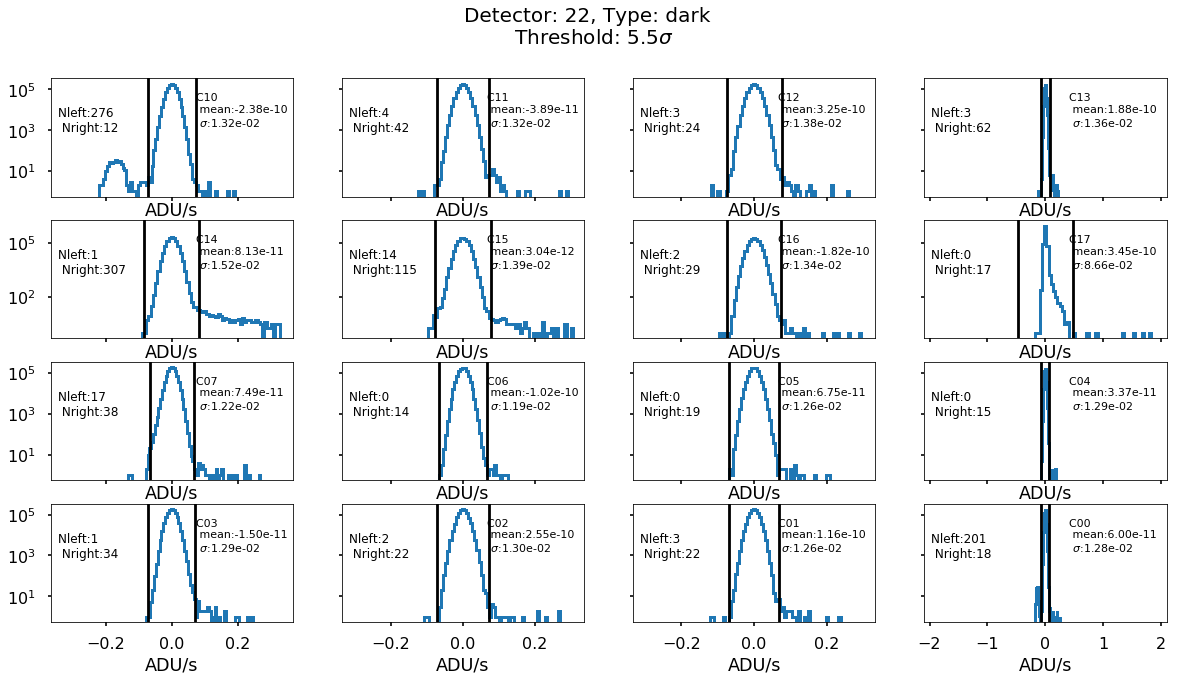

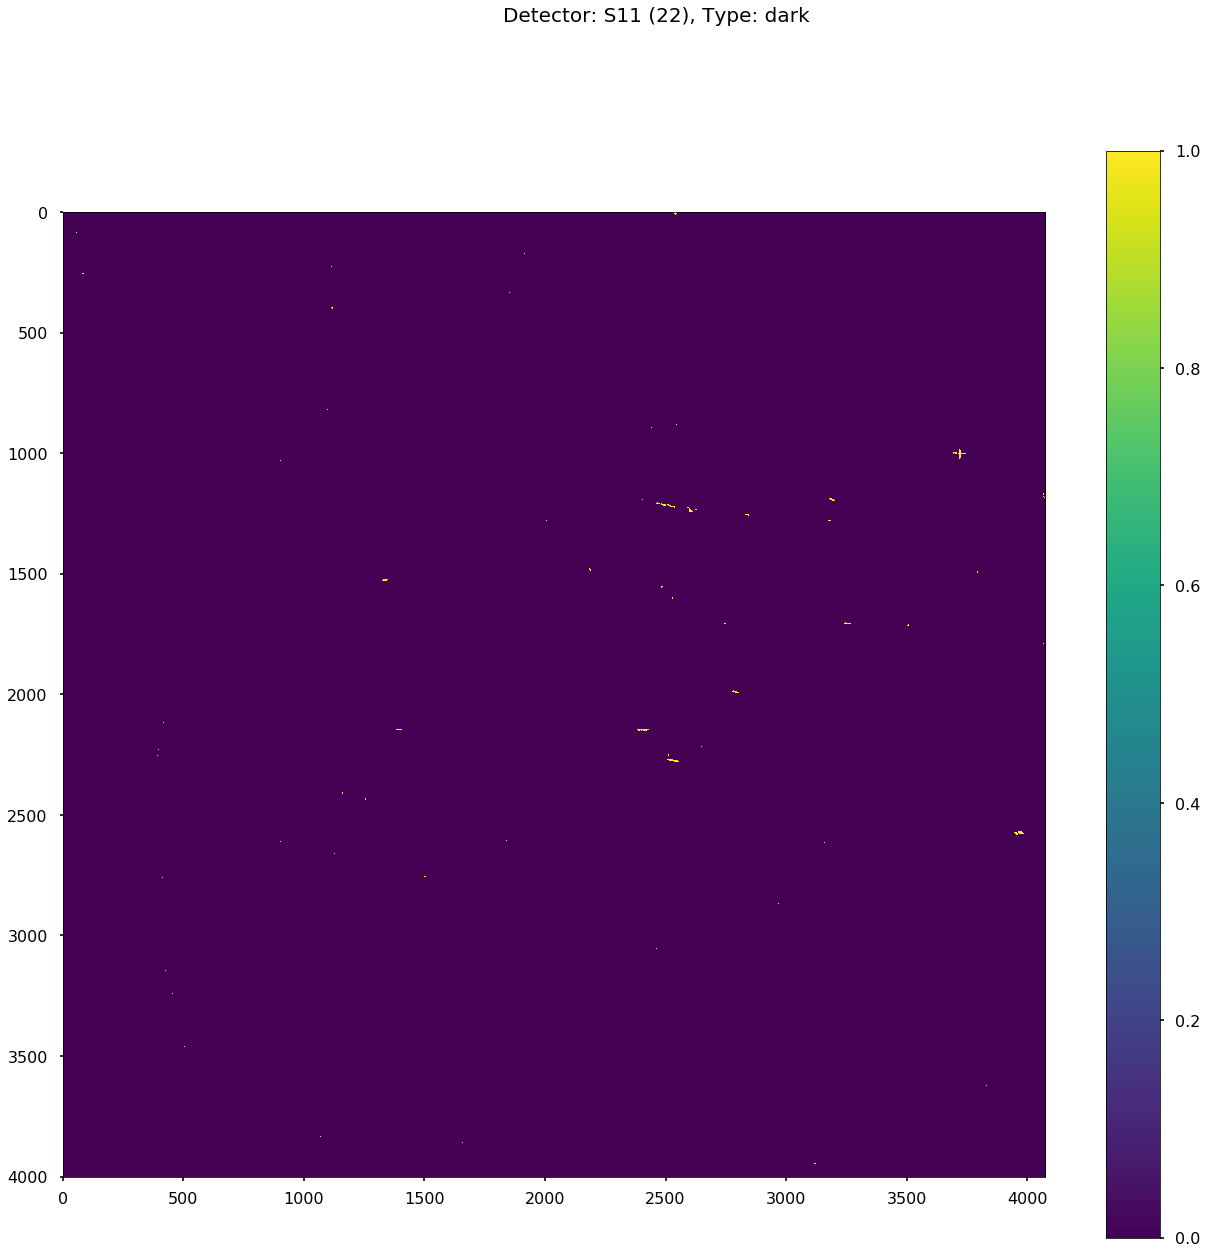

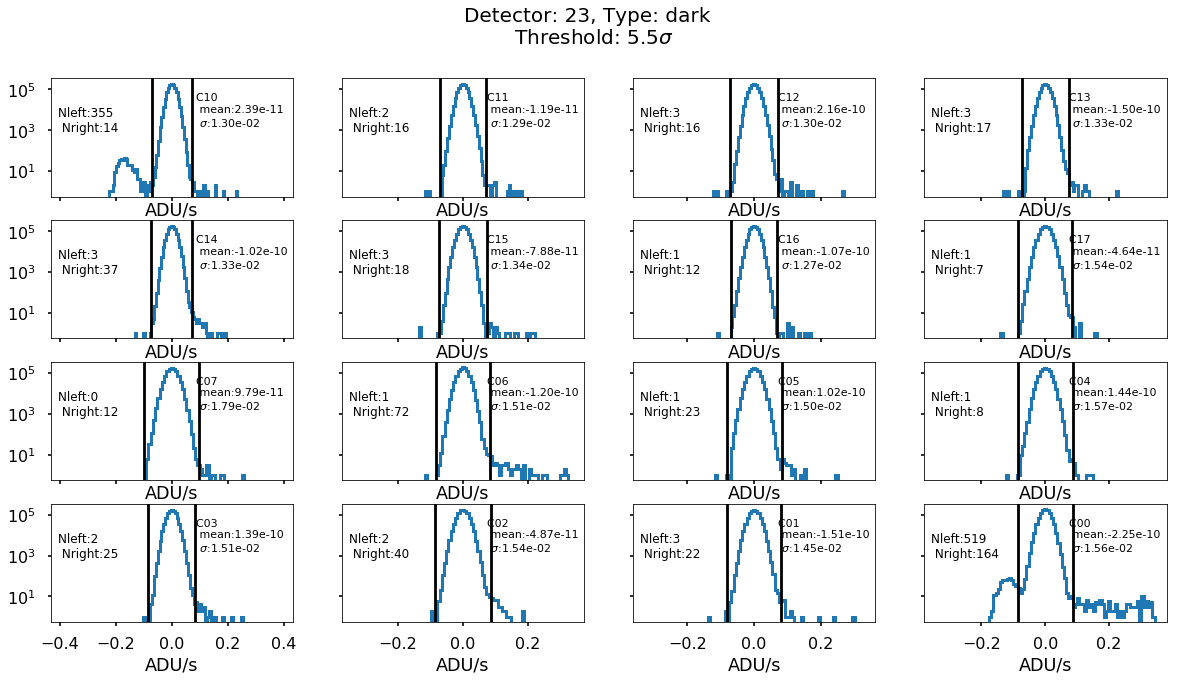

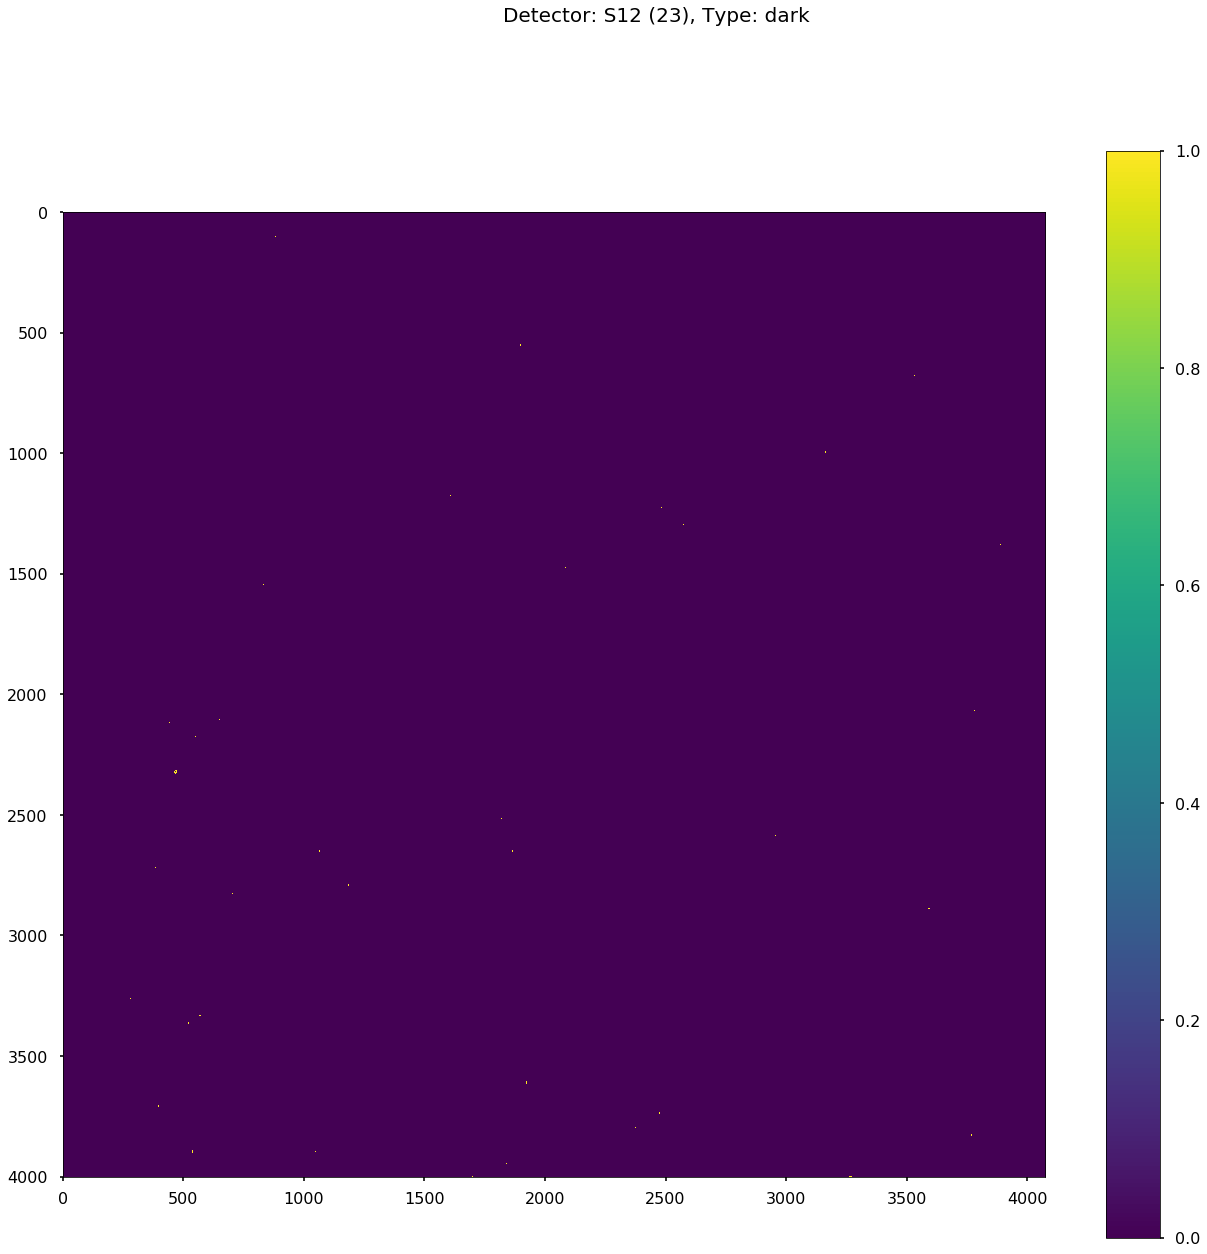

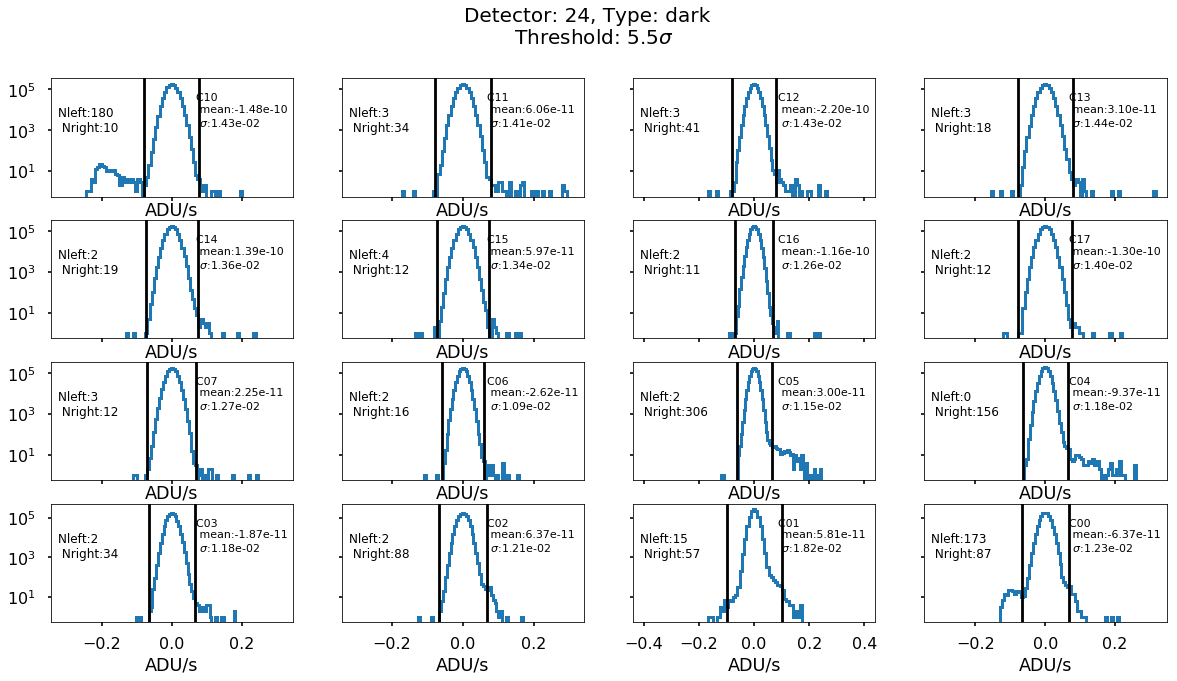

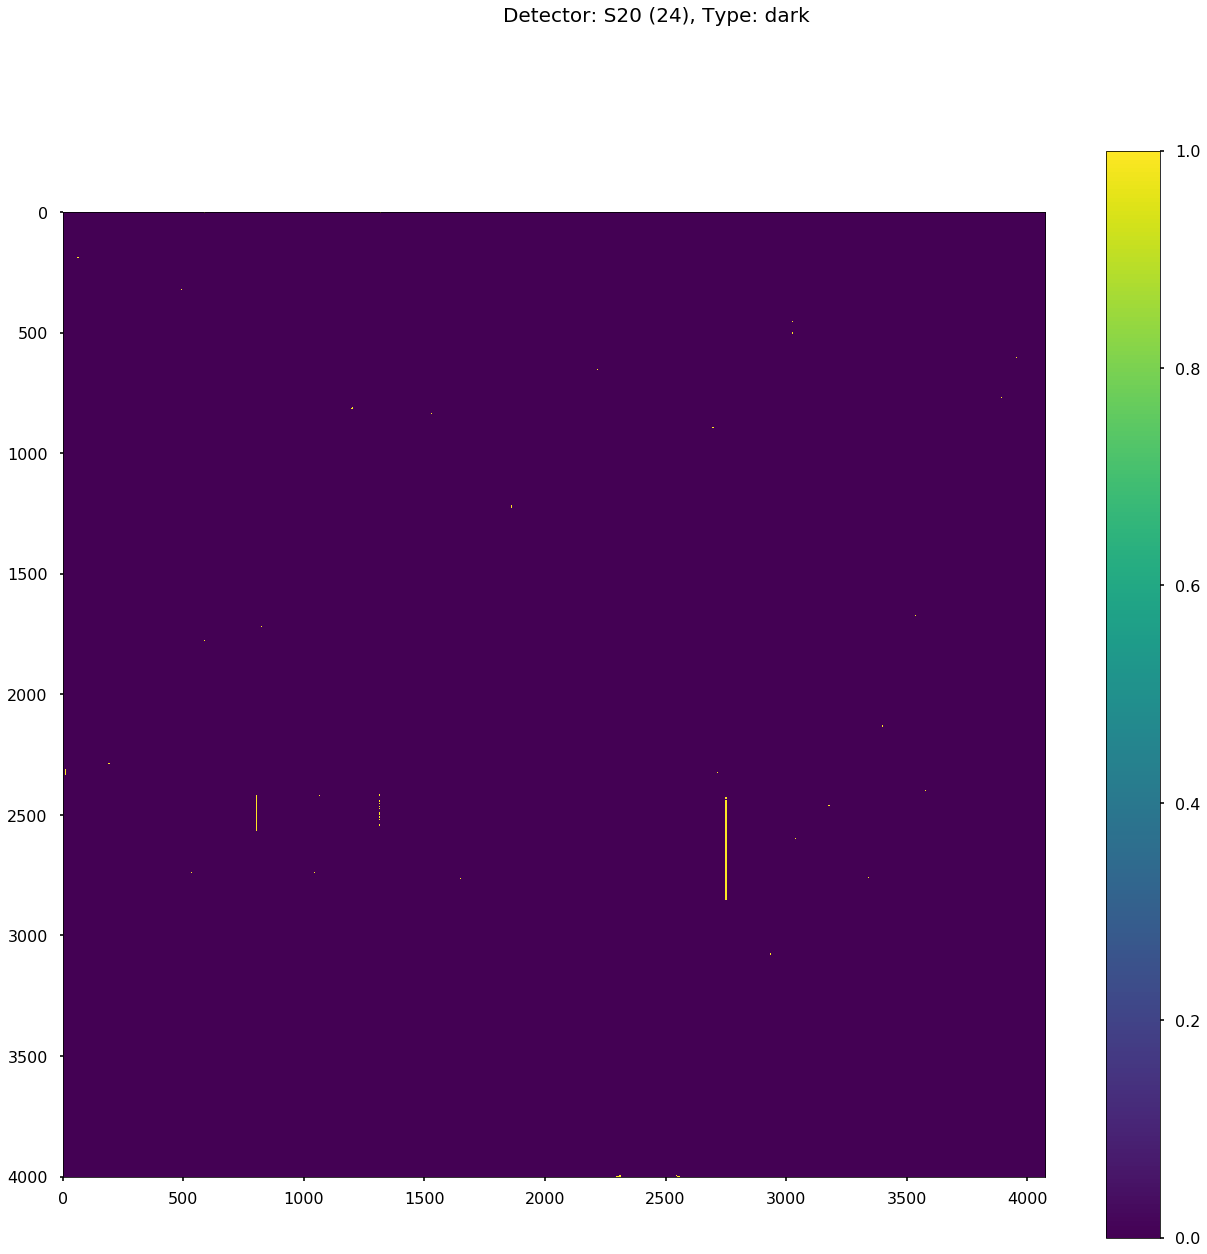

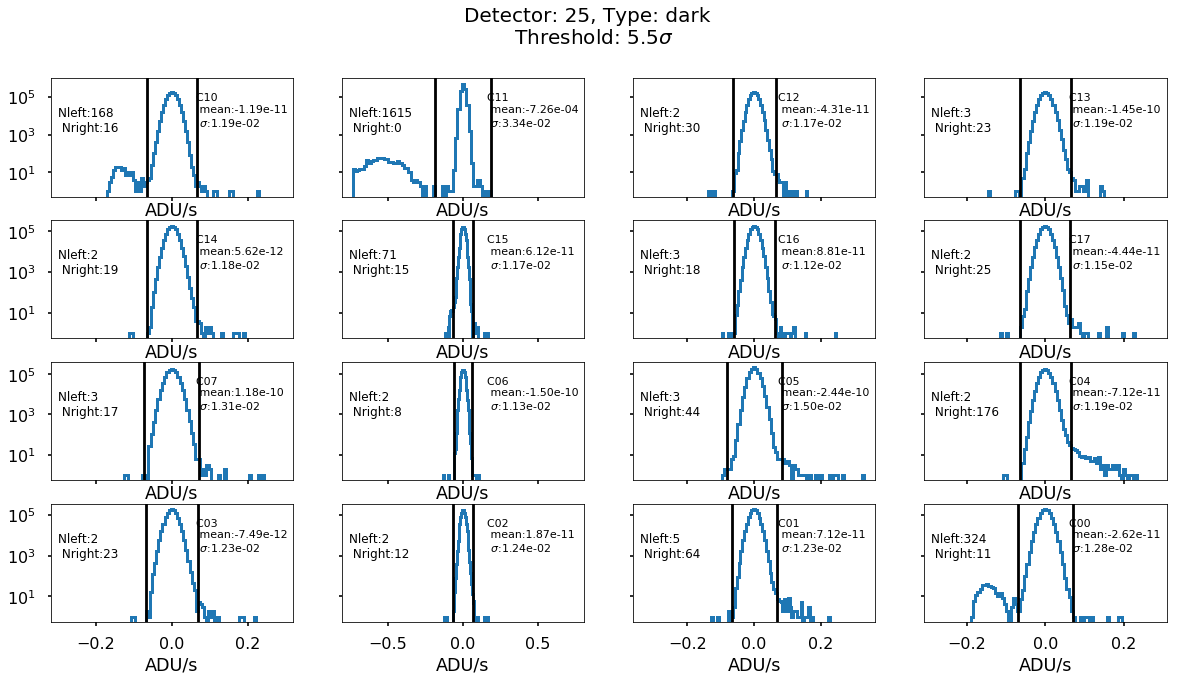

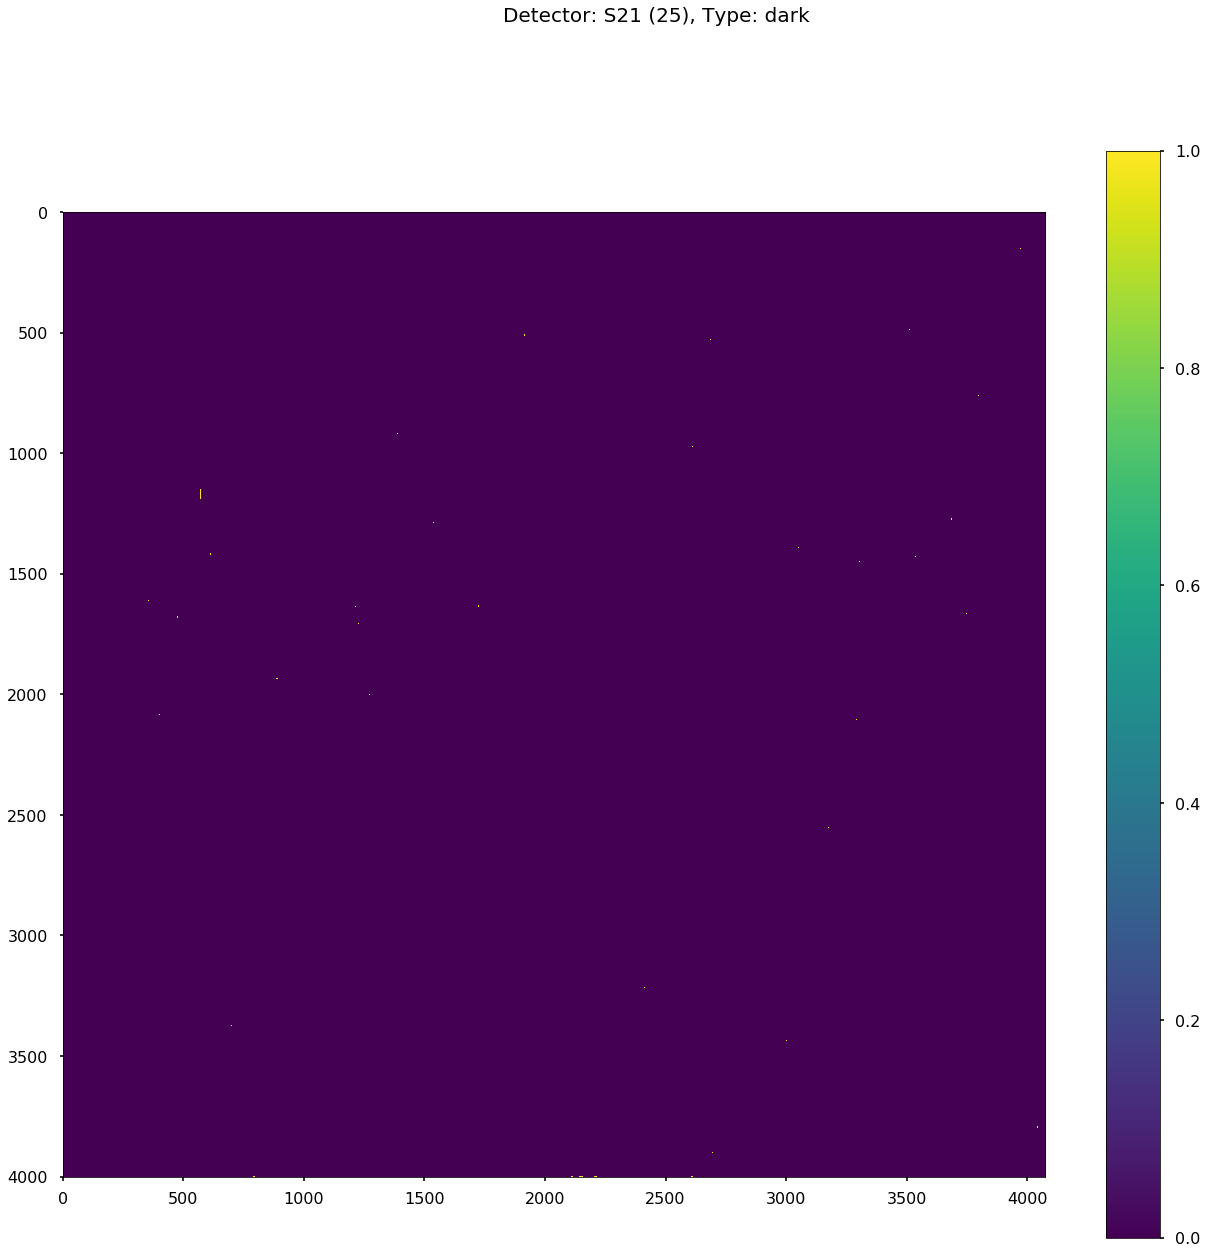

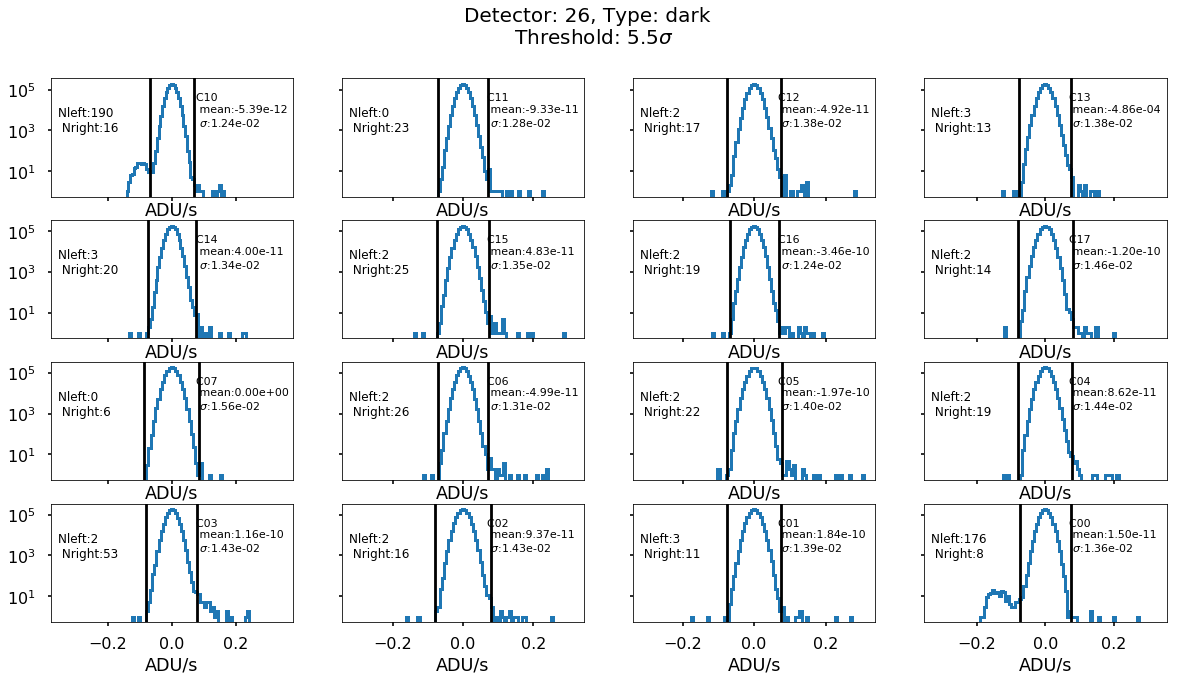

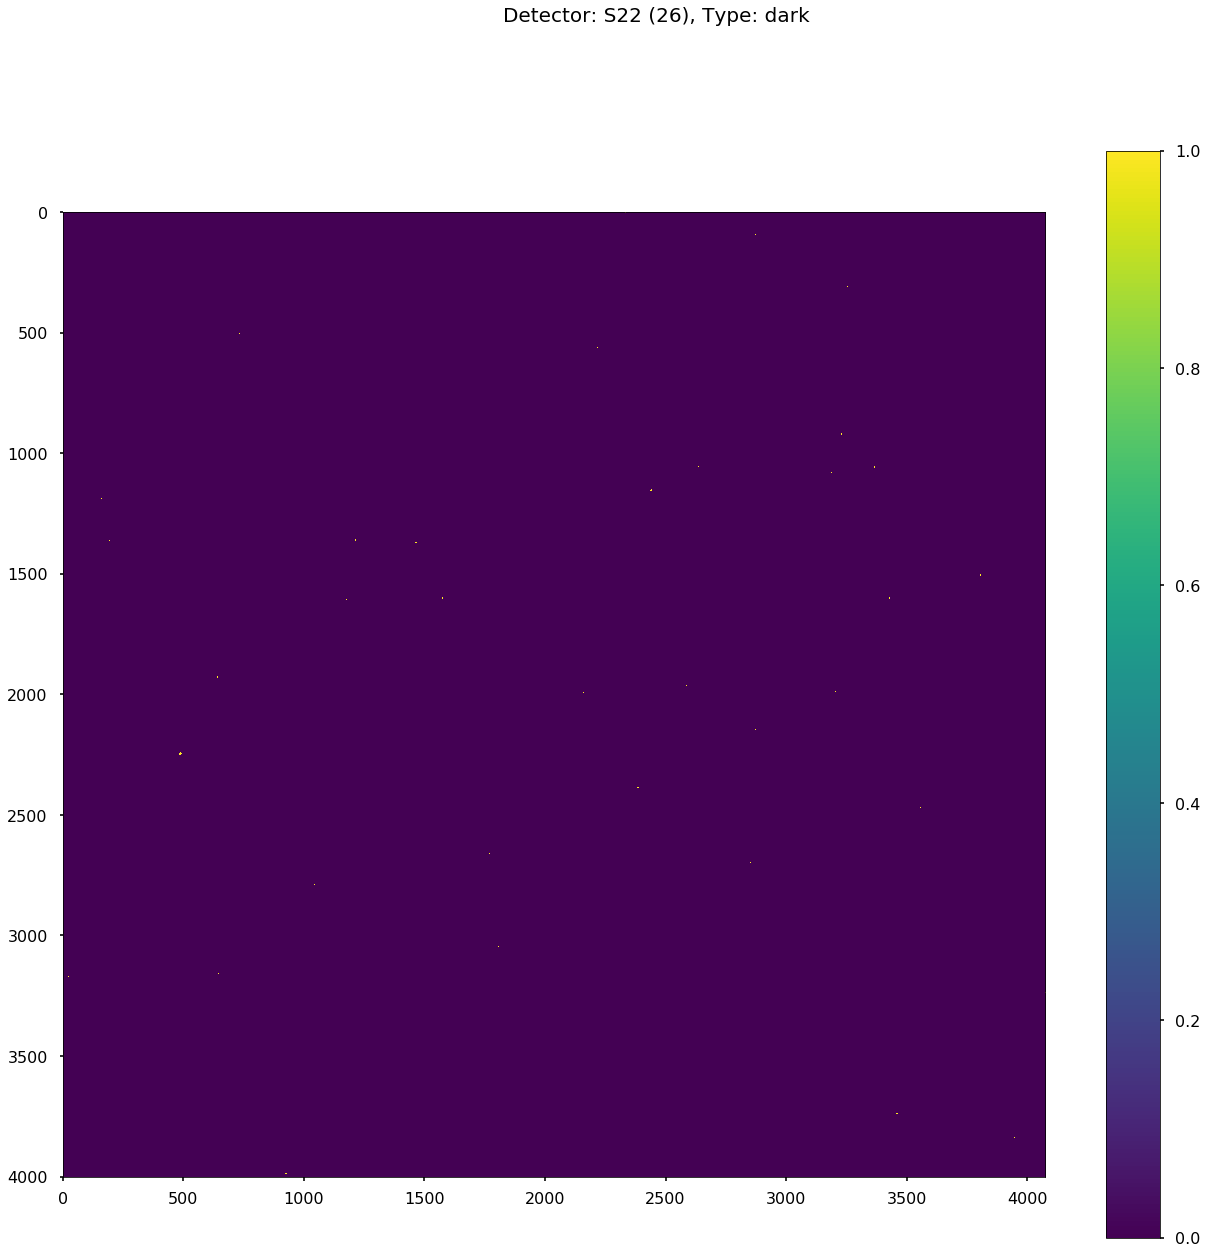

In [30]:
import matplotlib.backends.backend_pdf

pdf_bool=True

det_dict={20: 'S02', 21: 'S10', 22: 'S11', 23: 'S12', \
         24: 'S20', 25: 'S21', 26: 'S22', 18: 'S00', 19:'S01'}

#masterFlat = butler.get('flat', dataId = {'run': 9120, 'visit': r_band_flats[0], 'detector':22})
#bpm = hot_and_cold_pixels(butler, masterFlat, 18, pdf=False, number_of_sigma_threshold=5.5, polarity=False)

for tp in [('flat',False), ('dark',True)]: #type and polarity 
    pdf_out = matplotlib.backends.backend_pdf.PdfPages(f"defects_from_{tp[0]}.pdf")
    if tp[0] == 'flat':
        st = 5.0  #sigma threshold 
    elif tp[0] == 'dark':
        st = 5.5
    else:
        print ("Enter a valid type: 'flat' or 'dark' ")
        sys.exit(1) 
        
    for d in range(18,27):
        master = butler.get(tp[0], dataId = {'run': 9120, 'visit': r_band_flats[0], 'detector':d})
        bpm = hot_and_cold_pixels(master, type=tp[0], number_of_sigma_threshold=st, pdf=pdf_bool, detector=d, polarity=tp[1])
        bpm.run()
    
        fig=plt.figure(figsize=(22,20))
        plt.imshow(bpm.masked_image.mask.array, vmin=0, vmax=1)
        plt.colorbar()
        if pdf_bool:
            fig.suptitle(f"Detector: {det_dict[d]} ({d}), Type: {tp[0]}", fontsize=20)
            pdf_out.savefig(fig)
    pdf_out.close()